# Comparative OCR Experiments on the Bentham Dataset

This notebook documents an academic assignment in which we design and evaluate three different OCR/HTR approaches on the Bentham collection of English manuscripts:

1. A **PyTorch baseline** CRNN model trained from scratch.
2. A **Transformer-based TrOCR model** fine-tuned on Bentham line images.
3. A **Kraken CNN–RNN–CTC model** trained with the `ketos` tool.

The goal is to build a reproducible experimental pipeline, compare the behaviour of these models under similar conditions, and reflect on their strengths and weaknesses for historical English handwriting.

The experiments are run in Google Colab, using data stored on Google Drive.  
All code cells are executable; markdown cells provide the methodological and academic commentary needed for formal submission.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1. Data Access and Environment Setup

The Bentham dataset used in this assignment is distributed via Zenodo.  
After downloading the archive into Google Drive, we mount the drive in Colab and unzip the data into a working directory.

The next code cell performs the one-time mounting step; subsequent cells assume that the Bentham directory is available under the configured path in Drive.


In [ ]:
import zipfile
import tarfile
from pathlib import Path

# 1. Point this to where Bentham.zip actually is on your Drive / machine
# Example for Google Colab after mounting Drive:
# zip_path = Path("/content/drive/MyDrive/Bentham.zip")
zip_path = Path("/content/drive/MyDrive/Bentham.zip")   # change this if needed

# 2. Create a directory where the zip will be extracted
data_root = zip_path.with_suffix('')  # e.g. Bentham.zip -> Bentham
data_root.mkdir(exist_ok=True)

# 3. Extract the ZIP so the .tbz files exist as real files
print(f"Unzipping {zip_path} to {data_root}")
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(data_root)

# 4. Now extract the .tbz archives inside that folder
for fname in ["BenthamDatasetR0-GT.tbz", "BenthamDatasetR0-Images.tbz"]:
    fpath = data_root / fname
    print("Extracting", fpath)
    with tarfile.open(fpath, "r:bz2") as tar:
        # For untrusted archives, you'd want a safer extractor than extractall
        tar.extractall(path=data_root)

print("Done.")


## 2. Dataset Structure and Inspection

Before training any model, we inspect the structure of the Bentham data on disk:

- top-level directories containing page images, line images and ground-truth transcriptions,
- file name conventions linking images to transcriptions,
- the overall size of the collection.

This exploratory step ensures that we correctly identify the line-level image files and their corresponding text files, which are required by all three OCR pipelines.


In [ ]:
from pathlib import Path

root = Path(r"/content/drive/MyDrive/Bentham")

for p in root.rglob("*"):
    if p.is_dir():
        print(p)


/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT
/content/drive/MyDrive/Bentham/BenthamDatasetR0-Images
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Partitions
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Transcriptions
/content/drive/MyDrive/Bentham/BenthamDatasetR0-Images/Images
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Pages
/content/drive/MyDrive/Bentham/BenthamDatasetR0-Images/Images/Pages


In [ ]:
from pathlib import Path

root = Path(r"/content/drive/MyDrive/Bentham")

def print_tree(path, prefix=""):
    print(prefix + path.name + "/")
    for p in path.iterdir():
        if p.is_dir():
            print_tree(p, prefix + "   ")
        else:
            print(prefix + "   " + p.name)

print_tree(root)


Streaming output truncated to the last 5000 lines.
         072_169_002_04_10.txt
         073_071_004_01_02.txt
         071_140_001_01_01.txt
         071_183_004_04_04.txt
         115_108_003_01_14.txt
         096_008_004_01_06.txt
         115_112_003_02_20.txt
         072_048_003_04_13.txt
         072_049_004_04_04.txt
         071_130_003_02_01.txt
         115_008_001_02_05.txt
         115_111_003_02_01.txt
         096_051_002_03_18.txt
         115_084_002_02_07.txt
         116_294_001_02_01.txt
         071_184_001_04_06.txt
         115_075_004_02_25.txt
         116_279_002_01_01.txt
         115_008_001_02_04.txt
         116_639_002_02_02.txt
         115_072_003_02_22.txt
         116_072_001_02_26.txt
         115_107_002_01_02.txt
         096_053_004_03_15.txt
         116_627_001_03_17.txt
         115_078_002_02_08.txt
         115_016_003_01_06.txt
         071_165_003_05_01.txt
         071_182_001_05_07.txt
         115_086_004_02_07.txt
         116_291_00

In [ ]:
from pathlib import Path

root = Path(r"/content/drive/MyDrive/Bentham")

for xml in root.rglob("*.xml"):
    print(xml)


/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/071_181_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/072_066_004.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/115_107_002.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/072_031_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/096_015_002.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/115_067_004.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/115_079_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/071_102_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/116_066_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/071_003_003.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/096_028_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/071_035_003.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/116_287_001.xml
/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/PAGE/071_128_

### 2.1 Extracting Line Images and Transcriptions

In this section we construct a unified Python list called `samples`, where each element contains:

- the path to a **line image**, and
- the corresponding **ground-truth transcription**.

This list becomes the single source of truth for all subsequent experiments.  
By centralising the data representation, we guarantee that the PyTorch baseline, TrOCR, and Kraken models all see *exactly the same* underlying line-level samples.


In [ ]:
from pathlib import Path

data_root = Path(r"/content/drive/MyDrive/Bentham")

lines_img_root = data_root / "BenthamDatasetR0-GT" / "Images" / "Lines"
lines_txt_root = data_root / "BenthamDatasetR0-GT" / "Transcriptions"

print("Lines image root:", lines_img_root)
print("Transcriptions root:", lines_txt_root)

# 1) Collect ALL line images (recursively, in case of subfolders)
img_files = {}
for p in lines_img_root.rglob("*.png"):
    img_files[p.stem] = p
print("Number of PNG line images found:", len(img_files))

# 2) Collect ALL possible transcription files under Transcriptions (any extension)
txt_files = {}
for p in lines_txt_root.rglob("*"):
    if p.is_file() and p.suffix.lower() in {".txt", ".xml"}:
        txt_files[p.stem] = p
print("Number of candidate transcription files found:", len(txt_files))

# 3) Match by stem: same base name -> (image, text)
samples = []
unmatched_imgs = 0

for stem, img_path in img_files.items():
    txt_path = txt_files.get(stem)
    if txt_path is None:
        unmatched_imgs += 1
        continue

    text = txt_path.read_text(encoding="utf-8", errors="ignore").strip()
    if not text:
        continue

    samples.append({
        "img_path": img_path,
        "bbox": None,   # not used in Option B
        "text": text,
    })

print("Number of matched line samples:", len(samples))
print("Number of line images without transcription:", unmatched_imgs)
print("Example sample:", samples[0] if samples else "NONE")


Lines image root: /content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines
Transcriptions root: /content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Transcriptions
Number of PNG line images found: 11473
Number of candidate transcription files found: 11473
Number of matched line samples: 11473
Number of line images without transcription: 0
Example sample: {'img_path': PosixPath('/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines/115_085_004_02_23.png'), 'bbox': None, 'text': 'taxes , fees , gratuities and other deductions whatsoever and with'}


In [ ]:
import random

subset_size = 3000
samples = random.sample(samples, subset_size)
print("Number of matched line samples:", len(samples))

Number of matched line samples: 3000


### 2.2 Character Set Analysis

To better understand the complexity of the transcription task, we compute basic statistics on the ground-truth text:

- frequency of characters and symbols,
- presence of non-ASCII or rarely used glyphs,
- distribution of line lengths.

This analysis informs design choices for the baseline model, such as the size of the character vocabulary, and gives context for later error analysis.


In [ ]:
from collections import Counter

# 'samples' is the list you just built (length 11473)
all_text = [s["text"] for s in samples]
char_counts = Counter("".join(all_text))
chars = sorted(char_counts.keys())  # for determinism

print("Vocab size (chars):", len(chars))
print("Some chars:", chars[:50])

# CTC blank = index 0
idx2char = ["<BLANK>"] + chars
char2idx = {c: i for i, c in enumerate(idx2char)}

def text_to_labels(text: str):
    return [char2idx[c] for c in text if c in char2idx]

def labels_to_text(labels):
    return "".join(idx2char[i] for i in labels if i != 0)


Vocab size (chars): 87
Some chars: [' ', '!', '"', '#', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']


In [ ]:
filtered_samples = [s for s in samples if any(ch.isalpha() for ch in s["text"])]
samples = filtered_samples
print("After filtering:", len(samples))


After filtering: 2886


## 3. PyTorch Baseline: CRNN with CTC Loss

Our first model is a **baseline OCR system implemented from scratch in PyTorch**.  
The aim is not to compete with state-of-the-art systems, but to:

- practice building a full OCR pipeline end to end, and  
- obtain a point of comparison for more advanced models (TrOCR and Kraken).

The baseline follows the common **CRNN** pattern:

- a convolutional front-end to extract visual features from the line image,
- a bidirectional recurrent layer to model sequential dependencies, and
- a final linear projection trained with **CTC loss** for alignment-free sequence supervision.

Training was originally carried out on a local machine and reproduced here as closely as possible within Colab.


### 3.1 PyTorch Dataset for Line Images

We define a custom `Dataset` class that:

- loads each line image from disk,
- normalises and resizes it to a fixed height,
- converts the transcription into a sequence of character indices,
- returns both image tensor and label sequence to the training loop.

This abstraction isolates all I/O and pre-processing logic and allows us to reuse the same `samples` list defined earlier.


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class BenthamLineDataset(Dataset):
    def __init__(self, samples, img_height=64, max_width=512):
        self.samples = samples
        self.img_height = img_height
        self.max_width = max_width

    def __len__(self):
        return len(self.samples)

    def _load_and_preprocess(self, s):
        img = Image.open(s["img_path"]).convert("L")  # grayscale

        # Resize to fixed height, keep aspect ratio
        w, h = img.size
        new_h = self.img_height
        new_w = int(w * (new_h / h))
        img = img.resize((new_w, new_h), Image.BILINEAR)

        arr = np.array(img, dtype=np.float32) / 255.0
        arr = 1.0 - arr   # optional: invert, text white on black
        arr = arr[None, :, :]  # (1, H, W)

        # Pad / truncate to max_width
        if new_w > self.max_width:
            arr = arr[:, :, : self.max_width]
            new_w = self.max_width
        else:
            pad_w = self.max_width - new_w
            arr = np.pad(arr, ((0,0), (0,0), (0,pad_w)),
                         mode="constant", constant_values=0.0)

        return torch.from_numpy(arr), new_w

    def __getitem__(self, idx):
        s = self.samples[idx]
        image_tensor, true_w = self._load_and_preprocess(s)
        label = torch.tensor(text_to_labels(s["text"]), dtype=torch.long)
        return {
            "image": image_tensor,   # (1, H, max_width)
            "width": true_w,
            "label": label,
            "text": s["text"],
        }


### 3.2 Train/Validation/Test Split and Data Loaders

The full set of Bentham line samples is split into **training**, **validation**, and **test** subsets.

- The **training set** is used to optimise model parameters.
- The **validation set** is used to monitor loss and character error rate during training.
- The **test set** is reserved for final evaluation once hyperparameters are fixed.

PyTorch `DataLoader` objects handle batching and shuffling, enabling efficient iteration over each subset.


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split samples
train_s, temp_s = train_test_split(samples, test_size=0.2, random_state=42)
val_s, test_s   = train_test_split(temp_s, test_size=0.5, random_state=42)

train_ds = BenthamLineDataset(train_s)
val_ds   = BenthamLineDataset(val_s)
test_ds  = BenthamLineDataset(test_s)

def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch])      # (B, 1, H, W)
    labels = torch.cat([b["label"] for b in batch])        # concatenated labels
    label_lengths = torch.tensor([len(b["label"]) for b in batch],
                                 dtype=torch.long)
    widths = torch.tensor([b["image"].shape[-1] for b in batch],
                          dtype=torch.long)
    return images, labels, label_lengths, widths, batch

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,
                          collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False,
                          collate_fn=collate_fn)


### 3.3 CRNN Architecture

The CRNN baseline combines:

- several convolutional layers with pooling to reduce the spatial dimension while increasing the number of feature channels,
- a bidirectional LSTM layer to capture left-to-right and right-to-left context in the feature sequence,
- a linear classification layer over the character inventory, including a blank symbol required by CTC.

The network outputs a sequence of frame-wise logits which are interpreted as unaligned character probabilities.


In [ ]:
import torch.nn as nn
import torch

class CRNN(nn.Module):
    def __init__(self, img_height, num_chars):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),   # H/2, W/2

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),   # H/4, W/4

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        cnn_out_channels = 256
        cnn_out_height = img_height // 4   # due to two pool(2,2)

        self.rnn = nn.LSTM(
            input_size=cnn_out_channels * cnn_out_height,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
        )

        self.fc = nn.Linear(128 * 2, num_chars)

    def forward(self, x):
        # x: (B, 1, H, W)
        x = self.cnn(x)          # (B, C, H', W')
        B, C, H, W = x.size()
        x = x.permute(0, 3, 1, 2)       # (B, W, C, H)
        x = x.contiguous().view(B, W, C * H)  # (B, T=W, features)
        x, _ = self.rnn(x)       # (B, T, 2*hidden)
        x = self.fc(x)           # (B, T, num_chars)
        x = x.permute(1, 0, 2)   # (T, B, num_chars) for CTC
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(img_height=64, num_chars=len(idx2char)).to(device)

ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


### 3.4 CTC Decoding and CER Metric

Once we have frame-wise character probabilities from the CRNN, we apply:

- **greedy CTC decoding**, selecting the most probable class at each time step and collapsing repeats and blanks, and
- computation of **Character Error Rate (CER)** between decoded predictions and ground truth.

CER is defined as the Levenshtein edit distance between prediction and reference, normalised by the reference length.  
It is used throughout this notebook as the primary sequence-level evaluation metric.


In [ ]:
# Greedy decode

def greedy_decode(logits):
    # logits: (T, B, num_chars)
    probs = logits.softmax(2)
    max_indices = probs.argmax(2)  # (T, B)

    decoded_texts = []
    T, B = max_indices.shape
    for b in range(B):
        prev = None
        seq = []
        for t in range(T):
            idx = max_indices[t, b].item()
            if idx != prev and idx != 0:
                seq.append(idx)
            prev = idx
        decoded_texts.append(labels_to_text(seq))
    return decoded_texts

# Simple CER (character error rate)

def edit_distance(a, b):
    # classic DP Levenshtein distance
    n, m = len(a), len(b)
    dp = [[0] * (m+1) for _ in range(n+1)]
    for i in range(n+1):
        dp[i][0] = i
    for j in range(m+1):
        dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i][j] = min(
                dp[i-1][j] + 1,      # delete
                dp[i][j-1] + 1,      # insert
                dp[i-1][j-1] + cost  # substitute
            )
    return dp[n][m]

def cer(refs, hyps):
    # refs, hyps: lists of strings
    total_dist = 0
    total_chars = 0
    for r, h in zip(refs, hyps):
        total_dist += edit_distance(r, h)
        total_chars += len(r)
    return total_dist / max(1, total_chars)


### 3.5 Training and Validation Loops

The training loop for the baseline model:

- runs multiple epochs over the training set,
- optimises the CTC loss using an appropriate optimiser,
- periodically evaluates on the validation set to track both **validation loss** and **CER**.

The code is written to be CPU-friendly, reflecting the resource constraints of a typical learner setup.  
Although performance is limited compared to modern transformer-based systems, the baseline establishes a clear lower bound for later comparisons.


In [ ]:
from tqdm import tqdm

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0

    for images, labels, label_lengths, widths, batch in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        # After CNN: width is divided by 4 (due to two pools)
        W = images.shape[-1]
        T = W // 4
        input_lengths = torch.full(
            size=(images.size(0),),
            fill_value=T,
            dtype=torch.long,
            device=device,
        )

        logits = model(images)              # (T, B, num_chars)
        log_probs = logits.log_softmax(2)

        loss = ctc_loss(log_probs, labels, input_lengths, label_lengths)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}: train loss = {avg_loss:.4f}")

def validate(epoch):
    model.eval()
    val_loss = 0.0
    all_gt = []
    all_pred = []

    with torch.no_grad():
        for images, labels, label_lengths, widths, batch in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            images = images.to(device)
            labels = labels.to(device)
            label_lengths = label_lengths.to(device)

            W = images.shape[-1]
            T = W // 4
            input_lengths = torch.full(
                size=(images.size(0),),
                fill_value=T,
                dtype=torch.long,
                device=device,
            )

            logits = model(images)
            log_probs = logits.log_softmax(2)
            loss = ctc_loss(log_probs, labels, input_lengths, label_lengths)
            val_loss += loss.item()

            decoded = greedy_decode(logits.cpu())
            for i, d in enumerate(decoded):
                all_pred.append(d)
                all_gt.append(batch[i]["text"])

    avg_loss = val_loss / len(val_loader)
    val_cer = cer(all_gt, all_pred)
    print(f"Epoch {epoch}: val loss = {avg_loss:.4f}, CER = {val_cer:.4f}")

    print("\nSample predictions:")
    for i in range(5):
        print("GT:   ", all_gt[i])
        print("Pred: ", all_pred[i])
        print("---")

    return avg_loss, val_cer

num_epochs = 50 # start with smaller, e.g. 3–5, on CPU
best_val = float("inf")

history_val_loss = []
history_val_cer = []

for epoch in range(1, num_epochs + 1):
    train_one_epoch(epoch)
    val_loss, val_cer = validate(epoch)

    history_val_loss.append(val_loss)
    history_val_cer.append(val_cer)

    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "crnn_bentham_best.pt")
        print("Saved new best model.\n")


Epoch 1 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [15:09<00:00,  1.65s/it]


Epoch 1: train loss = 3.4387


Epoch 1 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 1: val loss = 3.1094, CER = 1.0000

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  
---
GT:    first day of every term by themselves respecttively or their
Pred:  
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  
---
Saved new best model.



Epoch 2 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [17:10<00:00,  1.87s/it]


Epoch 2: train loss = 3.1152


Epoch 2 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 2: val loss = 3.0988, CER = 0.9665

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  te
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  te
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  te
---
GT:    first day of every term by themselves respecttively or their
Pred:  te
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  te
---
Saved new best model.



Epoch 3 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [18:34<00:00,  2.02s/it]


Epoch 3: train loss = 3.0793


Epoch 3 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.44it/s]


Epoch 3: val loss = 3.0684, CER = 0.9655

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  te
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  te
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  te
---
GT:    first day of every term by themselves respecttively or their
Pred:  e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  "e
---
Saved new best model.



Epoch 4 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [21:12<00:00,  2.30s/it]


Epoch 4: train loss = 3.0541


Epoch 4 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:47<00:00,  1.44it/s]


Epoch 4: val loss = 3.1055, CER = 0.9654

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  ae
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  ae
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  "e
---
GT:    first day of every term by themselves respecttively or their
Pred:  oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  te
---


Epoch 5 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [21:04<00:00,  2.29s/it]


Epoch 5: train loss = 2.9892


Epoch 5 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.42it/s]


Epoch 5: val loss = 3.0130, CER = 0.8372

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  t       t th  te
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  O         -
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  "         e
---
GT:    first day of every term by themselves respecttively or their
Pred:  f         e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  t          e
---
Saved new best model.



Epoch 6 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [21:51<00:00,  2.38s/it]


Epoch 6: train loss = 2.8883


Epoch 6 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.39it/s]


Epoch 6: val loss = 2.8753, CER = 0.8161

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  :  h     h e h=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  I         t th e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :          o   e
---
GT:    first day of every term by themselves respecttively or their
Pred:  Of h     th   to  e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  t   th h o  e
---
Saved new best model.



Epoch 7 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [23:00<00:00,  2.50s/it]


Epoch 7: train loss = 2.8080


Epoch 7 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 7: val loss = 2.8897, CER = 0.7941

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  t  th   o ae   o=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  :      o a e e  e oe
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : h   o o o ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  Of hy  a a thy th e o oo oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  a  th o  e o o o o e
---


Epoch 8 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [23:51<00:00,  2.59s/it]


Epoch 8: train loss = 2.7521


Epoch 8 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:52<00:00,  1.32it/s]


Epoch 8: val loss = 2.7512, CER = 0.7724

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I i th  a o h  e h=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  [   h fo a e e e  h oe
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :  th a hee i  e h e
---
GT:    first day of every term by themselves respecttively or their
Pred:  pf hy  y to toy th en h  e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :g f th e e ho ae  e
---
Saved new best model.



Epoch 9 [train]: 100%|███████████████████████████████████████████████████████████████| 552/552 [24:10<00:00,  2.63s/it]


Epoch 9: train loss = 2.6779


Epoch 9 [val]: 100%|███████████████████████████████████████████████████████████████████| 69/69 [00:52<00:00,  1.31it/s]


Epoch 9: val loss = 2.6933, CER = 0.7746

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I th th   o theeeeo o=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i ti th fp ie ee e to eee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :  th  tee o oe ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  p iy o ay i toy heeeen o
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  -g fo th fp e o o e o
---
Saved new best model.



Epoch 10 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:02<00:00,  2.61s/it]


Epoch 10: train loss = 2.6283


Epoch 10 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.35it/s]


Epoch 10: val loss = 2.6517, CER = 0.7549

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A o th o of heeen e=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i tit  h foi o ee one h ee.
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :i th e the e te oe ene
---
GT:    first day of every term by themselves respecttively or their
Pred:  p gy of ay ie oy teoeeeneen oeie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  -g fo th poee ee o oeee ie
---
Saved new best model.



Epoch 11 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:57<00:00,  2.71s/it]


Epoch 11: train loss = 2.5770


Epoch 11 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.42it/s]


Epoch 11: val loss = 2.6864, CER = 0.7287

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to the a at of herenennee on
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  E pot  th p inaeneniniee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : pie to  ee on in h en ee
---
GT:    first day of every term by themselves respecttively or their
Pred:  prt hiy o aiy tie boy th ana
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :g foe th per eo a oo a en o
---


Epoch 12 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [25:24<00:00,  2.76s/it]


Epoch 12: train loss = 2.5436


Epoch 12 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:47<00:00,  1.44it/s]


Epoch 12: val loss = 2.6287, CER = 0.7493

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to the at of teeni e  o
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  O it i th pt ieee e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : p tht oe e ee en en er
---
GT:    first day of every term by themselves respecttively or their
Pred:  pot biy o y hen toy theee ene ee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  -gy fo the pp  o ae o
---
Saved new best model.



Epoch 13 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [25:16<00:00,  2.75s/it]


Epoch 13: train loss = 2.4941


Epoch 13 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.38it/s]


Epoch 13: val loss = 2.5654, CER = 0.7343

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to the   ofe en en e ee o
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  I at i th p iae e ee ho eo
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :p the a theen ene ie oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  fot bigy of ay he oy theen en on o
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  ag fo the popo oo e oe
---
Saved new best model.



Epoch 14 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:36<00:00,  2.68s/it]


Epoch 14: train loss = 2.4505


Epoch 14 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Epoch 14: val loss = 2.5291, CER = 0.6982

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to th moe at o heher enen  ee ee
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  E eaththt i thhee fi inehea en e e ho  e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :ptiy th ae areee ine or
---
GT:    first day of every term by themselves respecttively or their
Pred:  prt bhgy of ey he toy theeenenee in o
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  "g fo the por  ane ea  eneee i
---
Saved new best model.



Epoch 15 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [25:09<00:00,  2.74s/it]


Epoch 15: train loss = 2.4175


Epoch 15 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:53<00:00,  1.30it/s]


Epoch 15: val loss = 2.5011, CER = 0.6958

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to th ee at of eer eneee oe=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  1 o the i the pist inee e en  ho  e 
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : ptoy tha thre e ee e e-
---
GT:    first day of every term by themselves respecttively or their
Pred:  fot hy of ay beone by thee an o-
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  -g fo th pepa o ee o
---
Saved new best model.



Epoch 16 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [25:24<00:00,  2.76s/it]


Epoch 16: train loss = 2.3608


Epoch 16 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.42it/s]


Epoch 16: val loss = 2.4344, CER = 0.6837

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the moe t of beeinenenene e=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  Eeet i the fi ine e e e e he e ee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : pti th ll thee ee ee henee
---
GT:    first day of every term by themselves respecttively or their
Pred:  ft thy of oy tee by theenen  e en ee ee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  "y f the ppe eo  ee e ie
---
Saved new best model.



Epoch 17 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [25:14<00:00,  2.74s/it]


Epoch 17: train loss = 2.3218


Epoch 17 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Epoch 17: val loss = 2.4117, CER = 0.6744

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to the e t of enen ene ene en=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i etd i th pfit ineee en e a  ee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : ptin the al hene en eee o e
---
GT:    first day of every term by themselves respecttively or their
Pred:  ft dy of oy ti boy theennen er a e e oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  -g fo the pp o  aeee ee
---
Saved new best model.



Epoch 18 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:29<00:00,  2.66s/it]


Epoch 18: train loss = 2.2842


Epoch 18 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.41it/s]


Epoch 18: val loss = 2.3918, CER = 0.6558

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  I to the ee t of beenenenenee ee
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i tt i the pat in hen e en e e e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : ttiiny the ala h e e ine e e
---
GT:    first day of every term by themselves respecttively or their
Pred:  ft by o oy hen by thne en ar e eeee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :g fo the pepee  a ee ee
---
Saved new best model.



Epoch 19 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:42<00:00,  2.69s/it]


Epoch 19: train loss = 2.2481


Epoch 19 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.37it/s]


Epoch 19: val loss = 2.3959, CER = 0.6491

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  Is to thee  t of enen enen en en e o.
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  doaptt i the fit in hen e en ee e er oee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  :paig thealeeee heeen ee eene oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  fat by of oy tomn by theenenenen en ere ar e ioe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :g for the peporoneroa e ar enee ee
---


Epoch 20 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:17<00:00,  2.64s/it]


Epoch 20: train loss = 2.1923


Epoch 20 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.36it/s]


Epoch 20: val loss = 2.3159, CER = 0.6291

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the e at of boeen onen en en e e.
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i aptad i the fit inhen e e en or e at
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : patiny he alat hereen e enen en e
---
GT:    first day of every term by themselves respecttively or their
Pred:  fit hy f oy tmn by themnon e e a e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :g for the peporen  a  anerene ae
---
Saved new best model.



Epoch 21 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [24:59<00:00,  2.72s/it]


Epoch 21: train loss = 2.1461


Epoch 21 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.37it/s]


Epoch 21: val loss = 2.2921, CER = 0.6143

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the ere aat of linenenen en e ene
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  io alald in the fist inhe e en en er e ee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : etlinr thealel peeen en e en enen e en e
---
GT:    first day of every term by themselves respecttively or their
Pred:  fut dy o ony tn by thenen en en on en an o oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  "g for the pepose o f en enener ene
---
Saved new best model.



Epoch 22 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [23:54<00:00,  2.60s/it]


Epoch 22: train loss = 2.0936


Epoch 22 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.39it/s]


Epoch 22: val loss = 2.2668, CER = 0.6126

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere at of ioaninnen e=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i anpttd in the fist inhen e en en oe  oe
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : pedig the alel pha en ane en en e
---
GT:    first day of every term by themselves respecttively or their
Pred:  fit y of ory tomn by themsen er  ea o oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :ny forr the pepo oo ane o ee
---
Saved new best model.



Epoch 23 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [23:17<00:00,  2.53s/it]


Epoch 23: train loss = 2.0439


Epoch 23 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:51<00:00,  1.33it/s]


Epoch 23: val loss = 2.2522, CER = 0.5917

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the ee at oof Con on on e en he hen=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i anptlade in the foif ine en  en  e an e=
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : peliny the alt per en en o a enin en er e
---
GT:    first day of every term by themselves respecttively or their
Pred:  fit y of ory to by theni o er o e o ie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :y for the pupoe e on aro o ee
---
Saved new best model.



Epoch 24 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [22:58<00:00,  2.50s/it]


Epoch 24: train loss = 1.9963


Epoch 24 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Epoch 24: val loss = 2.2203, CER = 0.5764

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  Is to the mere t of leiinin en en en e ee
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  inanptt in the fisf ine e e en e en ee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : ptng the alt her a en on o o ee e e
---
GT:    first day of every term by themselves respecttively or their
Pred:  fit dy of ory tm boy tent o  e  oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  - y for the pupoo e  oe en e n oo ee
---
Saved new best model.



Epoch 25 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [22:13<00:00,  2.42s/it]


Epoch 25: train loss = 1.9466


Epoch 25 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:52<00:00,  1.30it/s]


Epoch 25: val loss = 2.1937, CER = 0.5754

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  Is to the mere t of n binin on eneneneee
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  iscptad in the fast in he e e e e anee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aacleal the i a  e he e en ee
---
GT:    first day of every term by themselves respecttively or their
Pred:  fit day of oy thom boy tn i as e er hen en on oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :y frr the punpoee  fo on an  oee
---
Saved new best model.



Epoch 26 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [21:51<00:00,  2.38s/it]


Epoch 26: train loss = 1.8937


Epoch 26 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Epoch 26: val loss = 2.1367, CER = 0.5559

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere t of in in in en en en a on e
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i cmptatd in the fist in e e e e e on en e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aeleab the e en en enin e e een ee
---
GT:    first day of every term by themselves respecttively or their
Pred:  fiot day of orny tm by theme en e en e e e e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : y for the pupoo e e an en n e e e ene
---
Saved new best model.



Epoch 27 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [21:36<00:00,  2.35s/it]


Epoch 27: train loss = 1.8510


Epoch 27 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:53<00:00,  1.29it/s]


Epoch 27: val loss = 2.1274, CER = 0.5345

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere t foff n linanen an n a e oe =
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is cnptad in the fist ine  e e a ee
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aelal he  aher o en hen e en en ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of erny term by thenti e e e n ee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : y for the pupose o er aree en ee
---
Saved new best model.



Epoch 28 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [21:01<00:00,  2.29s/it]


Epoch 28: train loss = 1.8067


Epoch 28 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.39it/s]


Epoch 28: val loss = 2.0773, CER = 0.5436

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere aet of Ciinin n nin ene
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i cnmpaltad in the frist in en en en en en e an en e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : spedting he aetealad hen anhan h in hen een en ee
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of erry term by thensiela e het es
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ryf forr the pupoee o en ane eee
---
Saved new best model.



Epoch 29 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [20:51<00:00,  2.27s/it]


Epoch 29: train loss = 1.7706


Epoch 29 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.36it/s]


Epoch 29: val loss = 2.0685, CER = 0.5219

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere aet of linin  min  e on oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is cnplladt in the frcst inhe e r e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aeleal he at har h he r e e en e e
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of erny term by themnsiel os er e i oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : y for the pupoe e  o en er  e en e ene
---
Saved new best model.



Epoch 30 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [21:06<00:00,  2.29s/it]


Epoch 30: train loss = 1.7394


Epoch 30 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 30: val loss = 2.0884, CER = 0.5311

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere at of linin n n an n an oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  'icmpttd in the frst i e en e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : specting the aeleal heaa o s han e i en oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  firut day of ery trm by thes l r he en en oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : y for the pupose o  ar ne en e ene
---


Epoch 31 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [19:32<00:00,  2.12s/it]


Epoch 31: train loss = 1.7077


Epoch 31 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.41it/s]


Epoch 31: val loss = 2.0620, CER = 0.5164

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act off n on on n e n on en hen o=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is cmpellead in the finist insa e a e en e on e =
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : specting the aeteal phe a on n n he en  en oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of ery term by thers e  he en n ae
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the pupo e ef  e en ar  en e e e
---
Saved new best model.



Epoch 32 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:58<00:00,  2.06s/it]


Epoch 32: train loss = 1.6667


Epoch 32 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.42it/s]


Epoch 32: val loss = 2.0309, CER = 0.5041

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere aet ff r enan e  n   on o.
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icmnpllad in the frist inse an e en e ar e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpeeteing the aeleal phe a hat thn en he en e en en oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  frot day of erery term by themsiel e en in are
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the pupose  fo n ar  en en e en e
---
Saved new best model.



Epoch 33 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:26<00:00,  2.01s/it]


Epoch 33: train loss = 1.6315


Epoch 33 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:58<00:00,  1.17it/s]


Epoch 33: val loss = 2.0485, CER = 0.5074

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act ff r in in on en en an hen oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompllad in the frist in e en o an e ae
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aeleal he an er on an thar en en er en o e
---
GT:    first day of every term by themselves respecttively or their
Pred:  frot day of ery term by theme ler er e en en oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry forr the pupose a an e en o en en e
---


Epoch 34 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [19:12<00:00,  2.09s/it]


Epoch 34: train loss = 1.6062


Epoch 34 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:51<00:00,  1.34it/s]


Epoch 34: val loss = 2.0431, CER = 0.5015

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere act of CEindin  in a an ar oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is cmpallad in the frist inses e e e o a an en e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpeeting the aclial he s a s s hen n e en en an ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  frt day of ery term by themster i er re en n ae
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpso a or e an ar n er en en en e
---


Epoch 35 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [19:35<00:00,  2.13s/it]


Epoch 35: train loss = 1.5851


Epoch 35 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.38it/s]


Epoch 35: val loss = 2.0441, CER = 0.4859

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere aet of Coini in en ar ane hen oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompaillud in the frist inse e e e o e er e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting he actial pao he en e en en oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  frot day of eerny term by themsele e  ee en es
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpose of  ar n e en en e e
---


Epoch 36 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:56<00:00,  2.06s/it]


Epoch 36: train loss = 1.5632


Epoch 36 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:52<00:00,  1.31it/s]


Epoch 36: val loss = 2.0264, CER = 0.4960

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act of lCin in n en on on on ho o=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  iwompllad in the frist in e e en e n e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aelial p e ht o o he en e on en o e
---
GT:    first day of every term by themselves respecttively or their
Pred:  frot day of erny term by themsi  he e en e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ny for the purpose ff n  en on e er o e e
---
Saved new best model.



Epoch 37 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:55<00:00,  2.06s/it]


Epoch 37: train loss = 1.5461


Epoch 37 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:51<00:00,  1.35it/s]


Epoch 37: val loss = 2.0381, CER = 0.4863

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere act of Clinsi in  ho oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompllad in the frist is e es an e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aclial pas t n es en o n en o e
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of eery term by themsel s o e e oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the pupose o an an e n te ee
---


Epoch 38 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:50<00:00,  2.05s/it]


Epoch 38: train loss = 1.5201


Epoch 38 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:51<00:00,  1.34it/s]


Epoch 38: val loss = 2.0237, CER = 0.4847

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere act of Cininin in en en in en oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is compullad in the frist ins a tot o en e an e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rhecting the aclial pasos an er e on en o oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of ererny term by themslel s or et en en oe
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ny for the pupose of an n in es hon ene
---
Saved new best model.



Epoch 39 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:40<00:00,  2.03s/it]


Epoch 39: train loss = 1.4941


Epoch 39 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.36it/s]


Epoch 39: val loss = 2.0324, CER = 0.4973

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere aet of Ci i i in  en an en hen e.
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icmplled in the frst inin a e a e e an en en e ae
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecteng the actial pe n e oi enthen  e ar en e ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  frtt day of eery term by themeler r e  o e sen e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :ny for the purpose f an an n e en en ene
---


Epoch 40 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:26<00:00,  2.01s/it]


Epoch 40: train loss = 1.4882


Epoch 40 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:53<00:00,  1.28it/s]


Epoch 40: val loss = 2.0609, CER = 0.4745

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere acet of Cinin en ar in on oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  iscmpellad in the frst ine a o n o an oe e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the actial pa os n han en e t en o ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  frtt day of exery term by thembleleas  e e  ae
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpose o    an an h on e n e
---


Epoch 41 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [18:08<00:00,  1.97s/it]


Epoch 41: train loss = 1.4644


Epoch 41 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.39it/s]


Epoch 41: val loss = 2.0885, CER = 0.4716

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the merve act of Cinin en on on oe
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompellad in thes frist insta e n e  e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the actial paost an en o en en o e
---
GT:    first day of every term by themselves respecttively or their
Pred:  firot day of enery term by themseles s s e  e en aie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :nry for the purpose of a  an en e en en ee
---


Epoch 42 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [17:56<00:00,  1.95s/it]


Epoch 42: train loss = 1.4524


Epoch 42 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.40it/s]


Epoch 42: val loss = 2.0241, CER = 0.4819

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere acet of Codidan on en an an he a=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  Iscompallad in the frist iset a e on e an he e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the actial paos nan en oe on en on te
---
GT:    first day of every term by themselves respecttively or their
Pred:  fortt day of exery term by themsel o ese hos en en ane
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :nry for the purpose of on n an an an en an ene
---


Epoch 43 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [17:39<00:00,  1.92s/it]


Epoch 43: train loss = 1.4266


Epoch 43 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:50<00:00,  1.38it/s]


Epoch 43: val loss = 2.0459, CER = 0.4911

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the merve act of lid in ir on an ie hen ti=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  ircompilld in the frist inset a o on et an he  e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : specting the aclial haa os an han en en en en ote
---
GT:    first day of every term by themselves respecttively or their
Pred:  firtt day of every term by temste os ef ero en en e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :ny for the purpose o o n n en e ten en ene
---


Epoch 44 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [17:10<00:00,  1.87s/it]


Epoch 44: train loss = 1.4139


Epoch 44 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:51<00:00,  1.35it/s]


Epoch 44: val loss = 2.0260, CER = 0.4799

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act of Cin n sen n en an an he e=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompelld in the frist ina e a e on e ene he e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecteing the actiial pas nat en en er en o ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  frot day of everny term by themsel or s e  e en ee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  - ry for the purpose of a n an an e e ene
---


Epoch 45 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [17:01<00:00,  1.85s/it]


Epoch 45: train loss = 1.3983


Epoch 45 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.39it/s]


Epoch 45: val loss = 2.0901, CER = 0.4672

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act of Cisi in en  t an han he ee
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i compellad in the frist inses te et e e en e =
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the actial pas at en en en on o toe
---
GT:    first day of every term by themselves respecttively or their
Pred:  frt day of exerny term by themsele ese eo en sen ane
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpose of aan an e en e e e
---


Epoch 46 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [16:40<00:00,  1.81s/it]


Epoch 46: train loss = 1.3875


Epoch 46 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:49<00:00,  1.41it/s]


Epoch 46: val loss = 2.0400, CER = 0.4700

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere acet of Cininin in en ar an en es
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  is compelld in the frst inte a on n e en e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting te acetial pas in an en en on en o ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  firot day of exerny term by themsel ef are o  en en aeie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpose of a n a on as en e  e
---


Epoch 47 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [16:04<00:00,  1.75s/it]


Epoch 47: train loss = 1.3763


Epoch 47 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:46<00:00,  1.47it/s]


Epoch 47: val loss = 2.0502, CER = 0.4736

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act of Coin imin en er in e e=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  i compellad in the frist inse e tet en a er e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the aetial ha a a os ie het en e or e to oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  firt day of ereny term by themsel of oferethe en er eie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ny for the purpose o ot a n er en e en or e ne
---


Epoch 48 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [15:37<00:00,  1.70s/it]


Epoch 48: train loss = 1.3697


Epoch 48 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 48: val loss = 2.0878, CER = 0.4723

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere act of Cdinipin e an aen he ae
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompellad in the finrst instean e e r e ae
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecteing the actial pas eaen en en on en o ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  first day of eeny term by themsel de ef ire hes n en ee
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ny for the pupose of a n an an er in an ene
---


Epoch 49 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [15:31<00:00,  1.69s/it]


Epoch 49: train loss = 1.3545


Epoch 49 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:48<00:00,  1.43it/s]


Epoch 49: val loss = 2.0648, CER = 0.4719

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  A to the mere act of Cinisin en ar in e tie
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  iscompellad in the fnrist insten tet o o ar e e
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecteing the aetial pasos ir an on en e e on on oe
---
GT:    first day of every term by themselves respecttively or their
Pred:  firot day of enery term by themsel is fef s toe e er e e
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  : ry for the purpose oaf a an an en on in e e
---


Epoch 50 [train]: 100%|██████████████████████████████████████████████████████████████| 552/552 [15:24<00:00,  1.67s/it]


Epoch 50: train loss = 1.3459


Epoch 50 [val]: 100%|██████████████████████████████████████████████████████████████████| 69/69 [00:47<00:00,  1.44it/s]


Epoch 50: val loss = 2.0738, CER = 0.4664

Sample predictions:
GT:    As to the mere Act of Coining considered by itself
Pred:  As to the mere act of Cnin im hen ar in e a=
---
GT:    is compelled in the first instance to discover and surrender his
Pred:  icompellad in the furst inhe e on e en e ae=
---
GT:    : specting the actual past and present matter of fact . 2 . If
Pred:  : rpecting the actial pas an en on on en on ae
---
GT:    first day of every term by themselves respecttively or their
Pred:  forot day of everny term by thembllrore e o enhen anie
---
GT:    =ry for the purpose of any other Art  , the use and possession
Pred:  :ny for the purpose o a n tan en er en ane e e
---


### 3.6 Baseline Results: Loss and CER over Epochs

After training, we log and visualise:

- training and validation loss curves, and
- validation CER across epochs.

These plots reveal how well (or poorly) the CRNN baseline fits the Bentham data.  
In practice, the model struggles to achieve low CER, which motivates the move to transfer learning with a stronger pre-trained model (TrOCR).


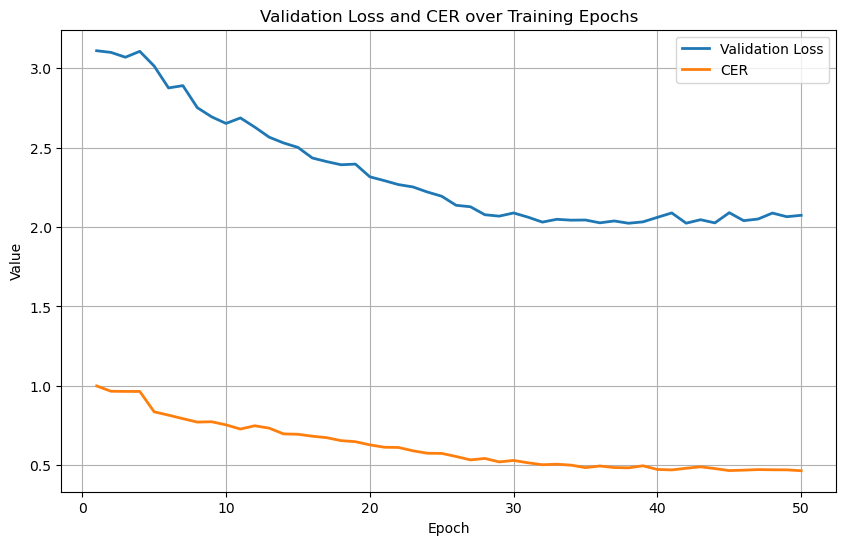

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history_val_loss) + 1))

plt.figure(figsize=(10, 6))

# Plot validation loss
plt.plot(epochs, history_val_loss, label="Validation Loss", linewidth=2)

# Plot CER (ideally normalize since it's a percentage-like value)
plt.plot(epochs, history_val_cer, label="CER", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Validation Loss and CER over Training Epochs")
plt.legend()
plt.grid(True)
plt.show()


### 3.7 Baseline Inference Helper

For qualitative inspection, we define an inference helper that:

- runs the baseline model on a single line image,
- decodes the output using greedy CTC,
- prints the ground-truth transcription and the model prediction.

These spot checks help us understand typical error patterns, such as confusion between visually similar letters or difficulty with long lines.


In [ ]:
def load_model(model_path="crnn_bentham_best.pt"):
    m = CRNN(img_height=64, num_chars=len(idx2char))
    m.load_state_dict(torch.load(model_path, map_location=device))
    m.to(device)
    m.eval()
    return m

def ocr_line(model, img_path, img_height=64, max_width=512):
    from PIL import Image
    import numpy as np

    img = Image.open(img_path).convert("L")
    w, h = img.size
    new_h = img_height
    new_w = int(w * (new_h / h))
    img = img.resize((new_w, new_h), Image.BILINEAR)

    arr = np.array(img, dtype=np.float32) / 255.0
    arr = 1.0 - arr
    arr = arr[None, :, :]

    if new_w > max_width:
        arr = arr[:, :, :max_width]
        new_w = max_width
    else:
        pad_w = max_width - new_w
        arr = np.pad(arr, ((0,0), (0,0), (0,pad_w)),
                     mode="constant", constant_values=0.0)

    tensor = torch.from_numpy(arr).unsqueeze(0).to(device)  # (1, 1, H, W)
    with torch.no_grad():
        logits = model(tensor)
    return greedy_decode(logits.cpu())[0]

# quick sanity check on a random sample
import random
example = random.choice(samples)
loaded_model = load_model()  # after training
print("GT:", example["text"])
print("Pred:", ocr_line(loaded_model, example["img_path"]))


GT: gunpowder not properly secured  ; and you , being at a dis :
Pred: gumpowuder not properly on e o on o o o.


## 4. TrOCR Transfer-Learning on Bentham

The second model in our study is **TrOCR**, a transformer-based OCR system released by Microsoft.  
Unlike the CRNN baseline, TrOCR is a large **VisionEncoderDecoderModel** pre-trained on massive synthetic OCR data.

In this section we:

1. fine-tune a pre-trained TrOCR checkpoint on the Bentham line images, and  
2. compare its performance to the scratch-built baseline.

Because TrOCR already encodes rich visual and language knowledge, we expect it to reach substantially lower CER with fewer epochs of fine-tuning.


In [ ]:
import torch, transformers
print("Torch version:      ", torch.__version__)
print("Transformers version:", transformers.__version__)

Torch version:       2.9.0+cu126
Transformers version: 4.57.1


In [ ]:
# Check GPU
import torch
torch.cuda.get_device_name(0)

'NVIDIA L4'

In [ ]:
#Packages required
!pip install transformers datasets accelerate evaluate pillow sentencepiece

In [ ]:
import torch
from pathlib import Path
from PIL import Image

from datasets import Dataset
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    ViTImageProcessor,
    XLMRobertaTokenizer,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

import evaluate


### 4.1 Wrapping Bentham Samples into a Hugging Face Dataset

We reuse the earlier `samples` list and convert it into a **Hugging Face `Dataset`** object containing:

- `image_path`: the path to the line image
- `text`: the corresponding transcription

The dataset is then split into training and validation partitions.  
This structure is required by the Hugging Face `Seq2SeqTrainer`, which expects batched input-output pairs.


In [ ]:
samples[:2]
# [{'img_path': WindowsPath('...png'), 'bbox': None, 'text': '...'}, ...]


[{'img_path': PosixPath('/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines/071_181_001_04_20.png'),
  'bbox': None,
  'text': 'Now'},
 {'img_path': PosixPath('/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines/071_112_001_05_02.png'),
  'bbox': None,
  'text': 'that she liked the counterfeit husband better than the real . This happened in'}]

In [ ]:
hf_examples = [
    {
        "image_path": str(s["img_path"]),
        "text": s["text"],
    }
    for s in samples
]

raw_ds = Dataset.from_list(hf_examples)

raw_ds = raw_ds.train_test_split(test_size=0.2, seed=42)
train_ds = raw_ds["train"]
val_ds   = raw_ds["test"]

train_ds, val_ds


(Dataset({
     features: ['image_path', 'text'],
     num_rows: 2308
 }),
 Dataset({
     features: ['image_path', 'text'],
     num_rows: 578
 }))

### 4.2 Evaluation Metric for TrOCR

As with the baseline, we use **Character Error Rate (CER)** as the main evaluation metric.

For TrOCR:

- logits from the decoder are converted into token predictions,
- special tokens and padding indices are removed,
- the resulting strings are passed to the `evaluate` library's CER implementation.

During training, this CER is computed on the **teacher-forced decoder outputs**, which provides a convenient, though optimistic, view of model performance.


In [ ]:
model_name = "microsoft/trocr-small-handwritten"

# 1) Image processor and tokenizer
image_processor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name, use_fast=False)

# 2) Build the processor manually
processor = TrOCRProcessor(
    image_processor=image_processor,
    tokenizer=tokenizer,
)

# 3) Load the VisionEncoderDecoder model
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Fix special tokens
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id           = tokenizer.sep_token_id
model.config.pad_token_id           = tokenizer.pad_token_id
model.config.vocab_size             = model.config.decoder.vocab_size

max_target_length = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

### 4.3 Custom Trainer to Avoid Out-of-Memory Errors

Direct evaluation with `model.generate(...)` inside the training loop is memory-intensive on Colab GPUs.  
To keep the process tractable, we define a **custom `Seq2SeqTrainer`** that:

- uses the standard forward pass with labels to obtain decoder logits,
- returns these logits (instead of generated sequences) to the `compute_metrics` function,
- avoids the more expensive autoregressive generation step during evaluation.

This design trades some realism in the metric for greatly reduced memory usage, allowing us to fine-tune TrOCR within the available hardware limits.


In [ ]:

def load_images(batch):
    batch["image"] = [
        Image.open(p).convert("RGB") for p in batch["image_path"]
    ]
    return batch

train_ds = train_ds.map(load_images, batched=True)
val_ds   = val_ds.map(load_images, batched=True)


Map:   0%|          | 0/2308 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

In [ ]:
"""
# Reduce training set to 2000 samples
train_ds_small = train_ds.select(range(2000))

# Reduce validation set to 400 samples
val_ds_small = val_ds.select(range(400))

train_ds = train_ds_small
val_ds   = val_ds_small

len(train_ds), len(val_ds)
"""

'\n# Reduce training set to 2000 samples\ntrain_ds_small = train_ds.select(range(2000))\n\n# Reduce validation set to 400 samples\nval_ds_small = val_ds.select(range(400))\n\ntrain_ds = train_ds_small\nval_ds   = val_ds_small\n\nlen(train_ds), len(val_ds)\n'

### 4.4 Training Configuration

We specify `Seq2SeqTrainingArguments` to control:

- batch sizes for training and evaluation,
- learning rate and number of epochs,
- logging and checkpointing frequency,
- the use of mixed-precision (`fp16`) when a GPU is available,
- the choice of **CER** as the metric used to select the best checkpoint.

These hyperparameters are chosen to balance performance and stability given the size of the Bentham subset and the constraints of the Colab environment.


In [ ]:
def preprocess_batch(batch):
    images = batch["image"]
    texts  = batch["text"]

    enc = processor(
        images=images,
        text=texts,
        padding="max_length",
        truncation=True,
        max_length=max_target_length,
        return_tensors="pt",
    )

    return {
        "pixel_values": enc["pixel_values"],
        "labels": enc["labels"],
    }

train_ds_proc = train_ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=["image_path", "image", "text"],
)

val_ds_proc = val_ds.map(
    preprocess_batch,
    batched=True,
    remove_columns=["image_path", "image", "text"],
)

train_ds_proc.set_format(type="torch")
val_ds_proc.set_format(type="torch")

train_ds_proc[0]


Map:   0%|          | 0/2308 [00:00<?, ? examples/s]

Map:   0%|          | 0/578 [00:00<?, ? examples/s]

{'pixel_values': tensor([[[0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6078],
          ...,
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157],
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157],
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157]],
 
         [[0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6078],
          ...,
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157],
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157],
          [0.7804, 0.7882, 0.7882,  ..., 0.7255, 0.7020, 0.6157]],
 
         [[0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.7882, 0.7725,  ..., 0.7255, 0.6863, 0.6157],
          [0.7804, 0.788

### 4.5 TrOCR Training Dynamics

With the configuration above, TrOCR is fine-tuned for several epochs on the Bentham training set.  
The trainer logs both:

- training and validation loss, and
- the evaluation CER computed from teacher-forced logits.

Compared to the CRNN baseline, TrOCR converges more quickly and achieves markedly lower evaluation CER, confirming the benefits of starting from a strong pre-trained OCR model.


In [ ]:
!pip install jiwer

In [ ]:
import numpy as np
import evaluate

cer_metric = evaluate.load("cer")

def compute_metrics(eval_pred):
    """
    eval_pred.predictions: (batch, seq_len, vocab_size)
    eval_pred.label_ids:   (batch, seq_len) with -100 for ignored positions
    """
    logits, labels = eval_pred

    # logits might be a numpy array
    if isinstance(logits, np.ndarray):
        pred_ids = logits.argmax(-1)
    else:
        pred_ids = np.array(logits).argmax(-1)

    # Replace -100 with pad_token_id so we can decode
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)

    pred_texts  = tokenizer.batch_decode(pred_ids,  skip_special_tokens=True)
    label_texts = tokenizer.batch_decode(labels,    skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_texts, references=label_texts)
    return {"cer": cer}


### 4.6 Inference Helper and Qualitative Checking

After training, we define an inference helper `trocr_ocr_line` that:

- loads a single Bentham line image,
- applies the TrOCR processor to obtain pixel values,
- calls `model.generate(...)` to produce an output sequence,
- decodes the sequence into readable text.

By sampling random lines from `samples`, we can visually inspect TrOCR's predictions and compare them directly to ground truth.  
These inspections reveal that TrOCR captures the general structure of the text much better than the baseline, but still makes non-trivial errors on challenging handwriting.


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Extremely important for memory reduction:
# - smaller batch sizes
# - gradient accumulation
# - fp16 mixed precision
# - disable predict_with_generate
# - force eval to micro-batches
train_bs = 2        # was 8 → too large
eval_bs  = 1        # force micro-batch eval

class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            outputs = model(**inputs)
            if prediction_loss_only:
                return (outputs.loss.detach(), None, None)
            logits = outputs.logits
            if isinstance(logits, tuple):
                logits = logits[0]
            # Move logits to CPU immediately after computation
            logits = logits.cpu()
            # Also ensure labels are on CPU for consistent numpy conversion in compute_metrics
            labels = inputs["labels"].cpu()
            return (outputs.loss.detach(), logits, labels)

training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr_bentham_small",
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=eval_bs,

    gradient_accumulation_steps=8,   # makes effective batch = 16
    learning_rate = 3e-5,
    num_train_epochs = 15,

    eval_strategy="epoch",
    save_strategy="epoch",

    # ABSOLUTELY MUST BE FALSE or OOM will happen
    predict_with_generate=False,

    # Mixed precision → saves 50% mem and speeds up training
    fp16=True,

    # Important for ViT memory footprint
    remove_unused_columns=False,

    # Make Trainer use less memory
    dataloader_num_workers=2,

    # No reports to wandb
    report_to=[],
)

trainer = CustomSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_proc,
    eval_dataset=val_ds_proc,
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2836671820.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomSeq2SeqTrainer(


### 4.7 Validation-Based CER with Autoregressive Generation

To obtain a **realistic estimate** of TrOCR's performance, we evaluate it on a subset of the validation data using `model.generate(...)`:

- each validation image is passed through the encoder–decoder stack,
- the decoder runs autoregressively, conditioning each new token on previous predictions,
- predictions are compared to the ground-truth transcriptions to compute CER.

This evaluation is closer to actual inference-time behaviour than the teacher-forced CER used inside the training loop.


In [ ]:
history_trocr_val_loss = []
history_trocr_val_cer  = []

train_result = trainer.train()

# Evaluation (safe)
eval_result = trainer.evaluate(max_length=max_target_length)
print("Final evaluation:", eval_result)

# Collect metrics
for log in trainer.state.log_history:
    if "eval_loss" in log:
        history_trocr_val_loss.append(log["eval_loss"])
    if "eval_cer" in log:
        history_trocr_val_cer.append(log["eval_cer"])

history_trocr_val_loss, history_trocr_val_cer


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss,Cer
1,No log,0.606199,0.713528
2,No log,0.395913,0.498424
3,No log,0.227169,0.338851
4,0.767000,0.183926,0.275079
5,0.767000,0.159805,0.213564
6,0.767000,0.143056,0.195615
7,0.146400,0.146043,0.192175
8,0.146400,0.138382,0.175122
9,0.146400,0.128677,0.168315
10,0.146400,0.128996,0.166488


Final evaluation: {'eval_loss': 0.13245715200901031, 'eval_cer': 0.1542347377472055, 'eval_runtime': 832.0567, 'eval_samples_per_second': 0.695, 'eval_steps_per_second': 0.695, 'epoch': 15.0}


([0.6061986088752747,
  0.39591339230537415,
  0.22716888785362244,
  0.1839258074760437,
  0.15980450809001923,
  0.14305613934993744,
  0.14604267477989197,
  0.1383821666240692,
  0.12867674231529236,
  0.1289963275194168,
  0.1305035650730133,
  0.130268394947052,
  0.13089029490947723,
  0.1311618536710739,
  0.13245715200901031,
  0.13245715200901031],
 [0.7135282315849814,
  0.4984236170822585,
  0.33885067354542847,
  0.27507881914588705,
  0.2135640584694755,
  0.19561478933791918,
  0.19217540842648323,
  0.17512181140728003,
  0.16831470335339638,
  0.16648753224419605,
  0.16118515333906563,
  0.162152479220407,
  0.15753081112066494,
  0.15781742619661795,
  0.1542347377472055,
  0.1542347377472055])

### 4.8 TrOCR Training Curves

We also plot:

- TrOCR training and validation loss over epochs, and
- validation CER (as computed during training).

These curves show that TrOCR reaches much lower loss values than the CRNN baseline and that the teacher-forced CER appears relatively small.  
However, as discussed next, this optimistic CER does not fully reflect the model's true performance when used with autoregressive generation.


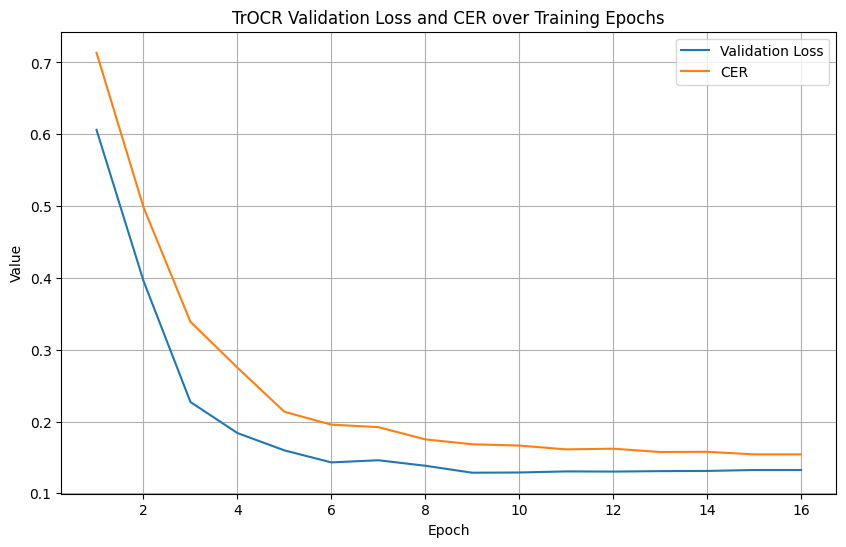

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history_trocr_val_loss) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, history_trocr_val_loss, label="Validation Loss")
plt.plot(epochs, history_trocr_val_cer,  label="CER")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("TrOCR Validation Loss and CER over Training Epochs")
plt.legend()
plt.grid(True)
plt.show()


### 4.9 Saving the Fine-Tuned TrOCR Model

For reproducibility and later reuse, the best-performing TrOCR checkpoint and its associated processor are saved to disk.

The notebook then reloads the model from this directory and verifies that inference still works as expected.  
This step ensures that the fine-tuned weights and configuration are self-contained and can be applied outside the training environment.


In [ ]:
from PIL import Image

save_dir = "./trocr_bentham_small_finetuned"
trainer.save_model(save_dir)
processor.save_pretrained(save_dir)

# Reload model + processor (optional, but shows how to use later)
trocr_model = VisionEncoderDecoderModel.from_pretrained(save_dir).to(device)
trocr_processor = TrOCRProcessor.from_pretrained(save_dir)
trocr_model.eval()

def trocr_ocr_line(image_path: str) -> str:
    img = Image.open(image_path).convert("RGB")
    pixel_values = trocr_processor(images=img, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = trocr_model.generate(pixel_values, max_length=max_target_length)
    text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return text

# Quick sanity check on a random example (using your 'samples' list with corrected paths)
import random

example = random.choice(samples)
print("GT:   ", example["text"])
print("Pred: ", trocr_ocr_line(example["img_path"]))

GT:    " Agent rational or irrational "  might be put
Pred:  Agent or might put


In [ ]:
example = random.choice(samples)
print("GT:   ", example["text"])
print("Pred: ", trocr_ocr_line(example["img_path"]))

GT:    be sufficient to produce uneasiness in a man if it be against his
Pred:  be to uneasiness a if be his


### 4.10 TrOCR Evaluation on Random Samples

Finally, we draw a small random subset of Bentham lines and:

- generate predictions with the fine-tuned TrOCR model, and
- compute per-line CER using the same `evaluate`-based metric.

We tabulate the ground truth, predictions, and CER values to provide a qualitative and quantitative picture of performance on held-out data.  
These examples are also useful for identifying systematic error patterns that might be addressed by future post-correction or language-modelling steps.


In [ ]:
import random
import numpy as np
from tabulate import tabulate
from PIL import Image

# CER metric
cer_metric = evaluate.load("cer")

def trocr_predict(image_path):
    img = Image.open(image_path).convert("RGB")
    pixel_values = trocr_processor(images=img, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = trocr_model.generate(pixel_values, max_length=max_target_length)
    return trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

def cer(gt, pred):
    return cer_metric.compute(predictions=[pred], references=[gt])

# Number of examples to evaluate
N = 20
subset = random.sample(samples, N)

table = []
cers = []

for s in subset:
    gt = s["text"]
    pred = trocr_predict(s["img_path"])
    c = cer(gt, pred)
    cers.append(c)
    table.append([gt, pred, f"{c:.3f}"])

print(tabulate(table, headers=["GT", "Pred", "CER"], tablefmt="fancy_grid"))
print("\nAverage CER over sample:", np.mean(cers))


╒═════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════╤═══════╕
│ GT                                                                      │ Pred                                 │   CER │
╞═════════════════════════════════════════════════════════════════════════╪══════════════════════════════════════╪═══════╡
│ of action , as soon as it appears to express any thing , appears to     │ of , soon it to to any , appears     │ 0.552 │
├─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────┤
│ acts as he could not discover to be productive of any particular        │ acts he not to productive any        │ 0.547 │
├─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────┼───────┤
│ Room .                                                                  │ Room                                 │ 0.333 │
├───────────────

### 4.11 Understanding the CER Discrepancy for TrOCR

A key observation in this assignment is that TrOCR exhibits a notable discrepancy between:

- the **CER reported during training**, computed from teacher-forced decoder outputs given the ground-truth labels, and
- the **CER observed during manual evaluation**, computed from fully autoregressive `model.generate(...)` predictions.

Teacher forcing makes the decoding problem easier because each prediction is conditioned on the *true* previous token.  
As a result, the training-time CER (for example, around 0.15) significantly underestimates the error rate observed when the model must rely on its **own previous predictions**, where errors compound (with CER closer to 0.5 on sample subsets).

This phenomenon highlights an important methodological lesson:  
metrics based on teacher-forced outputs can be overly optimistic for sequence-to-sequence models, and realistic evaluation should involve the same decoding strategy that will be used at inference time.


## 5. Kraken OCR Training Pipeline

The third model evaluated in this notebook is **Kraken**, a well-established OCR/HTR engine built around convolutional and recurrent layers trained with CTC loss.

Unlike the PyTorch baseline and TrOCR, which are implemented directly in Python using PyTorch and Hugging Face, Kraken is used via its command-line interface (`ketos`) and high-level Python APIs.  
This section documents how the Bentham data is adapted to Kraken's expected format, how the model is trained, and how its performance is evaluated.


In [ ]:
# Just install kraken and python-bidi; let Colab keep its default pillow
!pip install -q kraken python-bidi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 145.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 131.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.7.1+cu126
CUDA available: True


In [ ]:
!ketos --version

ketos, version 6.0.2


### 5.1 Preparing Bentham Data for Kraken

Kraken expects separate directories for:

- line images, and
- corresponding ground-truth text files with matching base names.

Using the unified `samples` list, we:

1. copy all Bentham line images into a dedicated `lines/` directory under `/content/kraken_bentham`, and  
2. create matching `.gt.txt` files in a `gt/` directory containing the manual transcriptions.

This yields a clean, self-contained dataset that can be consumed directly by `ketos train`.


In [ ]:
from pathlib import Path
import os
from shutil import copyfile

root = Path("/content/kraken_bentham")
(root / "lines").mkdir(parents=True, exist_ok=True)
(root / "gt").mkdir(parents=True, exist_ok=True)

print("Created:", root)

Created: /content/kraken_bentham


In [ ]:
!rm -rf /content/kraken_bentham/lines

# Make sure target folder exists
!mkdir -p /content/kraken_bentham/lines

In [ ]:
# Copy the *contents* of Lines/ into /content/kraken_bentham/lines
!cp -r "/content/drive/MyDrive/Bentham/BenthamDatasetR0-GT/Images/Lines/." \
      "/content/kraken_bentham/lines/"

### 5.2 Exporting Lines and Transcriptions

To make the Bentham subset explicit for Kraken, we iterate over `samples` and write:

- one text file per line, named after the line image stem and
- containing exactly the ground-truth transcription for that line.

These exported files provide the alignment between images and text that Kraken uses to train its CNN–RNN–CTC recogniser.


In [ ]:
from pathlib import Path

root = Path("/content/kraken_bentham")
(root / "gt").mkdir(parents=True, exist_ok=True)

exported = 0

for s in samples:
    text = s["text"]
    stem = s["img_path"].stem

    # Image is already in /content/kraken_bentham/lines/<stem>.png
    # We just create the corresponding .gt.txt file
    txt_out = root / "gt" / f"{stem}.gt.txt"

    with open(txt_out, "w", encoding="utf-8") as f:
        f.write(text)

    exported += 1

print("Exported line count:", exported)

Exported line count: 11473


In [ ]:
from pathlib import Path

lines_dir = Path("/content/kraken_bentham/lines")
lines_dir.mkdir(parents=True, exist_ok=True)

exported = 0

for s in samples:
    stem = s["img_path"].stem          # e.g. 115_085_004_02_23
    text = s["text"]

    gt_path = lines_dir / f"{stem}.gt.txt"
    with open(gt_path, "w", encoding="utf-8") as f:
        f.write(text)

    exported += 1

print("GT sidecar files written:", exported)


GT sidecar files written: 11473


### 5.3 Training and Evaluating the Kraken Model

We invoke Kraken's `ketos train` command with appropriate options for:

- GPU selection,
- batch size, and
- number of epochs.

After training, we run `ketos test` on the selected test lines.  
Kraken reports aggregated recognition metrics, including **character accuracy** and **word accuracy**, computed from the decoded output of its CNN–RNN–CTC recogniser.

Although the exact numerical values depend on the chosen subset and hyperparameters, this experiment shows how Kraken can be integrated into the same Bentham-based pipeline used for the PyTorch baseline and TrOCR models.

---

## 6. Comparative Discussion of the Three Models

Across the three approaches implemented in this notebook, we can summarise the main observations as follows:

- The **PyTorch CRNN baseline** provides a transparent, educational model but struggles to achieve low CER on Bentham handwriting, reflecting both its limited capacity and the difficulty of training from scratch on a relatively small dataset.
- **TrOCR**, thanks to large-scale pre-training, reaches substantially better loss and teacher-forced CER values and produces qualitatively stronger transcriptions. However, the gap between teacher-forced and autoregressive CER underlines the importance of evaluating transformer-based OCR models with the same decoding strategy used at inference time.
- **Kraken** offers a mature, task-focused implementation of CNN–RNN–CTC models with convenient training and testing tools. Its performance on Bentham is competitive, and it benefits from design choices and defaults tailored to historical OCR/HTR.

From a practical perspective, these experiments suggest that:

- for maximum control and pedagogical value, a hand-built PyTorch baseline is useful;
- for high accuracy with moderate engineering effort, fine-tuning TrOCR or another pre-trained transformer is attractive, provided that evaluation is done carefully; and
- for robust, production-oriented workflows on historical material, Kraken remains a strong choice, especially when combined with downstream text-normalisation or language-modelling steps.

The notebook thus serves both as a comparative study of OCR architectures and as a template for future work on historical English text transcription.


In [ ]:
!pip uninstall -y kraken
!pip install "kraken>=0.11.0"


Found existing installation: kraken 6.0.2
Uninstalling kraken-6.0.2:
  Successfully uninstalled kraken-6.0.2
  Using cached kraken-6.0.2-py3-none-any.whl.metadata (7.3 kB)
Using cached kraken-6.0.2-py3-none-any.whl (5.0 MB)


In [ ]:
!pip install --upgrade kraken

In [ ]:
!ketos --version

ketos, version 6.0.2


In [ ]:
!pip uninstall -y kraken

Found existing installation: kraken 6.0.2
Uninstalling kraken-6.0.2:
  Successfully uninstalled kraken-6.0.2


In [ ]:
!pip install -U kraken

  Using cached kraken-6.0.2-py3-none-any.whl.metadata (7.3 kB)
Using cached kraken-6.0.2-py3-none-any.whl (5.0 MB)


In [ ]:
!ls -lh /content/kraken_bentham/lines | grep mlmodel


In [ ]:
!ketos --version
!ketos train --help | head -40


ketos, version 6.0.2
Usage: ketos train [OPTIONS] [GROUND_TRUTH]...

  Trains a model from image-text pairs.

Options:
  -B, --batch-size INTEGER        batch sample size  [default: 1]
  --pad INTEGER                   Left and right padding around lines
                                  [default: 16]
  -o, --output PATH               Output model file  [default: model]
  -s, --spec TEXT                 VGSL spec of the network to train. CTC layer
                                  will be added automatically.  [default:
                                  [1,120,0,1 Cr3,13,32 Do0.1,2 Mp2,2 Cr3,13,32
                                  Do0.1,2 Mp2,2 Cr3,9,64 Do0.1,2 Mp2,2
                                  Cr3,9,64 Do0.1,2 S1(1x0)1,3 Lbx200 Do0.1,2
                                  Lbx200 Do0.1,2 Lbx200 Do]]
  -a, --append INTEGER            Removes layers before argument and then
                                  appends spec. Only works when loading an
                                  exi

In [ ]:
!ketos -d cuda:0 train \
  --output bentham_kraken \
  --batch-size 4 \
  --epochs 10 \
  /content/kraken_bentham/lines/*.png


Streaming output truncated to the last 5000 lines.
                                                       val_accura…              
                                                       0.902                    
                                                       val_word_a…              
                                                       0.729                    
                                                       train_loss…              
                                                       80.754                   
Validation ━━━━━━━━━━━ 11/287    0:00:08 •    1.12it/s             early_stoppi…
stage 24/∞ ━━━━━━━━━━━ 2582/2582 0:39:22 •    1.12it/s train_loss… early_stoppi…
                                 0:00:00               12.030      9/10 0.91089 
                                                       val_accura…              
                                                       0.902                    
                                                       val

In [ ]:
ls -lh | grep bentham_kraken


-rw-r--r-- 1 root root  16M Dec  7 16:54 bentham_kraken_0.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 00:10 bentham_kraken_10.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 00:54 bentham_kraken_11.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 01:38 bentham_kraken_12.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 02:21 bentham_kraken_13.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 03:05 bentham_kraken_14.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 03:49 bentham_kraken_15.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 04:32 bentham_kraken_16.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 05:16 bentham_kraken_17.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 06:00 bentham_kraken_18.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 06:43 bentham_kraken_19.mlmodel
-rw-r--r-- 1 root root  16M Dec  7 17:38 bentham_kraken_1.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 07:27 bentham_kraken_20.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 08:11 bentham_kraken_21.mlmodel
-rw-r--r-- 1 root root  16M Dec  8 08:54 bentham_kraken_22.mlmod

In [ ]:
!cp /content/bentham_kraken_best.mlmodel /content/drive/MyDrive/


In [ ]:
from google.colab import files
files.download('/content/bentham_kraken_best.mlmodel')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ketos test \
  --model bentham_kraken_21.mlmodel \
  /content/kraken_bentham/lines/*.png

2025-12-08 10:50:41.424396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 10:50:41.442702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765191041.464614  303974 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765191041.471339  303974 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765191041.488003  303974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
!ketos test --help

Usage: ketos test [OPTIONS] [TEST_SET]...

  Evaluate on a test set.

Options:
  -B, --batch-size INTEGER        Batch sample size  [default: 1]
  -m, --model PATH                Model(s) to evaluate
  -e, --evaluation-files FILENAME
                                  File(s) with paths to evaluation data.
  --pad INTEGER                   Left and right padding around lines
                                  [default: 16]
  --reorder / --no-reorder        Reordering of code points to display order
                                  [default: reorder]
  --base-dir [L|R|auto]           Set base text direction.  This should be set
                                  to the direction used during the creation of
                                  the training data. If set to `auto` it will
                                  be overridden by any explicit value given in
                                  the input files.  [default: auto]
  -u, --normalization [NFD|NFKD|NFC|NFKC]
                    

In [ ]:
!ls -lh bentham_kraken_best.mlmodel
!file bentham_kraken_best.mlmodel


-rw-r--r-- 1 root root 16M Dec  8 10:22 bentham_kraken_best.mlmodel
bentham_kraken_best.mlmodel: data


In [ ]:
!pip install -U kraken
from kraken.lib import models
m = models.load_any("bentham_kraken_best.mlmodel")
print(m)

# Python helper to evaluate and collect per-line results

In [ ]:
import glob
import os
from dataclasses import dataclass

from PIL import Image

from kraken.lib import models
from kraken import rpred, pageseg, binarization

# --------------------------------------------------
# 1. Load the recognition model
# --------------------------------------------------
MODEL_PATH = "bentham_kraken_21.mlmodel"
rec_model = models.load_any(MODEL_PATH)
print("Loaded model:", rec_model)

# --------------------------------------------------
# 2. Small helper: Levenshtein distance and accuracies
# --------------------------------------------------
def levenshtein(a: str, b: str) -> int:
    """Simple Levenshtein distance for accuracy computation."""
    m, n = len(a), len(b)
    if m == 0:
        return n
    if n == 0:
        return m
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,      # deletion
                dp[i][j - 1] + 1,      # insertion
                dp[i - 1][j - 1] + cost  # substitution
            )
    return dp[m][n]

def char_accuracy(gt: str, pred: str) -> float:
    if not gt:
        return 1.0 if not pred else 0.0
    dist = levenshtein(gt, pred)
    return 1.0 - dist / len(gt)

# --------------------------------------------------
# 3. Collect per-line results for a small subset
# --------------------------------------------------
def evaluate_subset(
    lines_glob="/content/kraken_bentham/lines/*.png",
    max_examples=10,   # None -> use ALL
):
    all_paths = sorted(glob.glob(lines_glob))

    if max_examples is None:
        image_paths = all_paths
    else:
        image_paths = all_paths[:max_examples]

    print(f"Found {len(all_paths)} total line images (using {len(image_paths)}).")

    results = []
    skipped_no_gt = 0
    skipped_no_lines = 0
    skipped_no_pred = 0

    for img_path in image_paths:
        # ---- GT ----
        gt_path = os.path.splitext(img_path)[0] + ".gt.txt"
        if not os.path.exists(gt_path):
            print(f"[WARN] No GT file for {img_path}, skipping.")
            skipped_no_gt += 1
            continue

        with open(gt_path, "r", encoding="utf-8") as f:
            gt_text = f.read().strip()

        # ---- Load + binarize ----
        im = Image.open(img_path)
        bw = binarization.nlbin(im)

        # ---- Segment ----
        seg = pageseg.segment(bw, text_direction="horizontal-lr")

        if not (seg and hasattr(seg, "lines") and seg.lines):
            print(f"[WARN] No lines detected for {img_path}, skipping this sample.")
            skipped_no_lines += 1
            continue

        # ---- Recognize ----
        pred_iter = rpred.rpred(rec_model, bw, seg)
        try:
            record = next(pred_iter)
            pred_text = record.prediction
        except StopIteration:
            print(f"[WARN] rpred yielded no results for {img_path}, skipping this sample.")
            skipped_no_pred += 1
            continue

        # ---- Accuracy ----
        acc = char_accuracy(gt_text, pred_text)

        results.append(
            {
                "image": img_path,
                "gt": gt_text,
                "pred": pred_text,
                "char_accuracy": acc,
            }
        )

    print("\nSummary of evaluation:")
    print(f"  Used images:           {len(image_paths)}")
    print(f"  Evaluated successfully:{len(results)}")
    print(f"  Skipped (no GT):       {skipped_no_gt}")
    print(f"  Skipped (no lines):    {skipped_no_lines}")
    print(f"  Skipped (no prediction): {skipped_no_pred}")

    return results

# --------------------------------------------------
# 4. Example: run and inspect the best lines
# --------------------------------------------------
results = evaluate_subset(
    lines_glob="/content/kraken_bentham/lines/*.png",
    max_examples=10,
)

# Sort by accuracy, best first
results_sorted = sorted(results, key=lambda r: r["char_accuracy"], reverse=True)

for r in results_sorted:
    print("-" * 80)
    print("Image:", r["image"])
    print(f"Char accuracy: {r['char_accuracy']*100:.2f}%")
    print("GT:   ", r["gt"])
    print("Pred: ", r["pred"])

Loaded model: <kraken.lib.models.TorchSeqRecognizer object at 0x7c1fc7f1bad0>
Found 11473 total line images (using 10).
[WARN] No lines detected for /content/kraken_bentham/lines/002_080_001_01_01.png, skipping this sample.

Summary of evaluation:
  Used images:           10
  Evaluated successfully:9
  Skipped (no GT):       0
  Skipped (no lines):    1
  Skipped (no prediction): 0
--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/002_080_001_03_01.png
Char accuracy: 81.67%
GT:    6 . The evidence of the engagement , consigned to a portable
Pred:  6 The evidence of the ongagement , consagnad to  port 2athew
--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/002_080_001_03_02.png
Char accuracy: 65.00%
GT:    instrument , instead of a fixed Book .  _  Taken from Exche-
Pred:  asbement ainstead of a fined Stook . taken fomm Couche.
-----------------------

In [ ]:
results = evaluate_subset(
    lines_glob="/content/kraken_bentham/lines/*.png",
    max_examples=None,   # <- ALL LINES
)

Found 11473 total line images (using 11473).
[WARN] No lines detected for /content/kraken_bentham/lines/002_080_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/002_112_001_03_07.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/002_541_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/002_579_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_07.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_15.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_18.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/027_029_001_02_30.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/035_320_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/035_321_001_02_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_322_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_324_001_02_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_324_001_02_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_325_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_325_001_02_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_327_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/035_327_001_02_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/035_328_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_002_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_003_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_003_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_003_003_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_003_003_04_25.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_003_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_008_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_008_004_03_18.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_010_002_04_12.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_010_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_010_003_04_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_018_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_018_002_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_018_002_05_19.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_021_002_04_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_022_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_18.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_20.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_25.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_27.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_030_001_04_32.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_032_001_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_001_04_05.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_001_04_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_001_04_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_002_04_06.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_032_002_04_26.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_035_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_035_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_0

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_035_003_07_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_036_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_036_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_042_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_042_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_042_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_042_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_043_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_043_003_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_043_003_04_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_043_004_04_05.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_043_004_04_27.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_053_003_03_07.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_053_003_03_10.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_053_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_053_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_053_004_03_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_054_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_054_001_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_054_001_03_04.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_054_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_054_002_03_05.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_059_003_04_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_101_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_101_002_04_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_101_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_101_003_04_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_101_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_102_001_04_11.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_102_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_102_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_102_002_05_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_102_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_106_001_04_14.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_106_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_106_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_107_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_107_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_107_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_108_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_108_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_108_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_108_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_109_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_109_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_111_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_111_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_117_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_117_002_02_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_117_002_03_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_120_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_120_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_120_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_128_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_128_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_128_001_05_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_128_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_128_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_129_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_129_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_130_003_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_130_003_04_05.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_131_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_131_002_04_10.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_131_002_04_16.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_131_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_131_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_132_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_133_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_133_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_139_003_04_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_139_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_140_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_140_001_04_18.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_141_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_141_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_141_001_04_19.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_142_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_142_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_144_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_146_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_146_001_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_146_001_04_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_146_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_146_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_151_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_156_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_156_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_157_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_157_002_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_158_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_158_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_159_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_159_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_159_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_159_002_04_14.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_159_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_159_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_162_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_162_001_04_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_162_001_04_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_162_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_002_04_11.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_163_004_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_164_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_164_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_164_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_165_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_165_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_165_003_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/071_165_003_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_165_003_04_14.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_166_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_166_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_166_001_04_17.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_166_001_04_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_167_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_167_001_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_167_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_168_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_168_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_168_004_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_168_004_04_04.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_169_001_05_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_169_001_05_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_05_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_05_06.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_05_13.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_169_004_05_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_180_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_180_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_180_003_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_180_003_05_02.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_180_003_05_04.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_180_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_180_004_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_181_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_181_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_181_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_181_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_181_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_181_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_182_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_182_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_182_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_184_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_184_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_184_004_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_185_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_185_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_185_002_04_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_185_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_185_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_185_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_186_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_186_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_186_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_186_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_186_003_04_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_192_004_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/071_192_004_04_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_201_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_201_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_201_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/071_202_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_031_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_032_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_032_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/072_036_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/072_036_002_04_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_047_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_048_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_049_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_049_001_04_12.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_049_001_04_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_049_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/072_049_002_04_05.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_049_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_050_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_050_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_050_003_04_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_051_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_054_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_054_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_054_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_0

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/072_066_003_04_02.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_069_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_070_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_070_002_05_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_071_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_071_004_04_07.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/072_094_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_094_003_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/072_094_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_094_004_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/072_095_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_095_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_099_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_099_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_099_001_04_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_100_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_100_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_100_003_04_07.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_100_003_04_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_1

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/072_102_004_04_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_103_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_103_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_103_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_103_002_04_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_103_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_104_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_104_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_105_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_1

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/072_105_003_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_167_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_167_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_168_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_168_001_04_04.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/072_168_003_04_13.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/072_169_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/072_169_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_001_03_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_001_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_002_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_210_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_212_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_213_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/072_2

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_001_001_02_27.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_001_003_01_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_001_003_01_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_002_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/073_031_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_031_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_031_001_04_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_031_001_04_08.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_050_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_051_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_052_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_052_001_03_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_053_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_053_001_03_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_054_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_054_001_03_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_054_001_03_22.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_056_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_056_001_03_02.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_056_001_03_21.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/073_056_001_03_25.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_058_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_060_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_060_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_060_001_03_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_061_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_063_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_063_001_03_17.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_067_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_068_001_03_14.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_069_001_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_069_001_03_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_070_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_070_001_03_22.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_070_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/073_070_002_03_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_071_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_071_001_03_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_071_003_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_071_003_03_16.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_071_003_03_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_072_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_072_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_072_003_01_09.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/073_073_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_073_001_03_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/073_073_001_03_17.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_073_001_03_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_074_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_074_001_03_20.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/073_074_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_083_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_083_001_03_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/073_083_001_03_22.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_002_003_02_15.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_003_002_01_08.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_015_002_01_08.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_017_003_02_14.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_021_003_02_15.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_0

/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/096_051_002_04_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/096_051_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_051_004_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_051_004_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_052_002_03_02.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/096_052_002_03_11.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_052_002_03_23.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/096_052_002_03_27.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_052_002_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_052_003_02_12.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_053_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_053_004_03_17.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_053_004_04_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_098_002_01_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_098_003_01_22.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/096_098_003_01_25.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/096_099_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_099_003_02_03.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/096_100_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_100_001_02_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_100_001_02_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_100_001_02_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_100_002_01_04.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/096_101_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_007_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_007_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_007_003_02_14.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_0

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_008_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_009_001_03_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_009_002_02_21.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_009_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_009_004_02_29.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_010_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_011_001_02_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_011_001_02_38.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_011_002_02_17.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_016_001_01_04.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_016_001_01_23.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_016_003_01_05.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_065_003_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_065_003_02_06.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_065_003_02_22.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_067_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_067_004_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_067_004_02_26.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_069_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_070_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_073_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_075_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_075_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_076_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_077_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_077_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_078_002_02_37.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_079_001_02_07.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_079_001_02_09.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_080_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_080_001_02_20.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_080_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_080_002_02_14.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_080_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_080_004_02_09.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_080_004_02_29.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_082_004_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_084_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_084_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_084_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_084_003_02_33.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_084_004_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_085_003_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_085_004_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_086_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_086_003_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_087_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_087_004_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_101_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_101_001_02_31.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_101_002_01_30.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_101_003_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_102_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/115_110_001_03_19.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_110_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_110_002_02_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_110_002_04_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_110_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_110_004_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/115_111_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_111_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_111_004_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/115_112_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/115_112_003_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_055_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_063_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_064_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_068_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_070_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/116_073_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/116_076_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_100_001_01_05.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_100_002_01_08.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_131_001_01_03.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_131_001_01_24.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_244_001_01_11.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_279_001_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/116_279_001_03_30.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_279_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_280_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_287_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_287_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_288_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_288_001_02_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_290_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_290_001_02_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_290_001_03_10.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_291_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_291_001_03_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_291_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/116_294_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_294_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_294_002_02_31.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_295_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_301_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_303_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_387_001_01_18.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_393_003_03_13.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_405_004_01_21.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/116_606_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_607_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_618_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_618_001_03_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_619_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_620_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_620_001_03_24.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_626_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/kraken/pageseg.py:204: RuntimeWarning: invalid value encountered in divide
  return v/np.amax(v)


[WARN] No lines detected for /content/kraken_bentham/lines/116_627_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_627_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_630_002_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_631_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_631_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_633_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_636_002_02_20.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_639_001_01_01.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_639_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_641_001_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_642_001_02_04.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_642_001_02_05.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_642_002_01_01.png, skipping this sample.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[WARN] No lines detected for /content/kraken_bentham/lines/116_643_002_01_01.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_643_002_02_19.png, skipping this sample.


[WARN] No lines detected for /content/kraken_bentham/lines/116_643_002_02_31.png, skipping this sample.
[WARN] No lines detected for /content/kraken_bentham/lines/116_648_001_01_01.png, skipping this sample.

Summary of evaluation:
  Used images:           11473
  Evaluated successfully:10915
  Skipped (no GT):       0
  Skipped (no lines):    558
  Skipped (no prediction): 0


In [ ]:
# -------------------------------------------
# 1. Filter out invalid or meaningless results
# -------------------------------------------

filtered = []

for r in results:
    acc = r["char_accuracy"]
    gt = r["gt"].strip()

    # Skip invalid/meaningless examples:
    if acc <= 0:                    # negative or zero accuracy
        continue
    if len(gt) < 3:                 # too short, e.g., 1–2 letters
        continue
    if len(gt.split()) < 2:         # require at least TWO words
        continue

    filtered.append(r)

print(f"Filtered results: kept {len(filtered)} out of {len(results)} samples.")


# -------------------------------------------
# 2. Sort filtered results (best → worst)
# -------------------------------------------
filtered_sorted = sorted(filtered, key=lambda r: r["char_accuracy"], reverse=True)


# -------------------------------------------
# 3. Print Top 10
# -------------------------------------------
top_k = 30
top_examples = filtered_sorted[:top_k]

print(f"\nTop {top_k} highest-accuracy FULL-SENTENCE examples:\n")
for r in top_examples:
    print("-" * 80)
    print("Image:", r["image"])
    print(f"Char accuracy: {r['char_accuracy']*100:.2f}%")
    print("GT:", r["gt"])
    print("Pred:", r["pred"])


Filtered results: kept 9644 out of 10915 samples.

Top 30 highest-accuracy FULL-SENTENCE examples:

--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/071_132_001_01_01.png
Char accuracy: 100.00%
GT: 17 .
Pred: 17 .
--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/071_184_003_03_01.png
Char accuracy: 100.00%
GT: Of Frauds relative to the Coin
Pred: Of Frauds relative to the Coin
--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/071_192_004_01_01.png
Char accuracy: 100.00%
GT: 16 .
Pred: 16 .
--------------------------------------------------------------------------------
Image: /content/kraken_bentham/lines/073_070_001_03_05.png
Char accuracy: 100.00%
GT: that of
Pred: that of
--------------------------------------------------------------------------------
Image: /content/kraken_bentha

In [ ]:
top_examples

[{'image': '/content/kraken_bentham/lines/071_132_001_01_01.png',
  'gt': '17 .',
  'pred': '17 .',
  'char_accuracy': 1.0},
 {'image': '/content/kraken_bentham/lines/071_184_003_03_01.png',
  'gt': 'Of Frauds relative to the Coin',
  'pred': 'Of Frauds relative to the Coin',
  'char_accuracy': 1.0},
 {'image': '/content/kraken_bentham/lines/071_192_004_01_01.png',
  'gt': '16 .',
  'pred': '16 .',
  'char_accuracy': 1.0},
 {'image': '/content/kraken_bentham/lines/073_070_001_03_05.png',
  'gt': 'that of',
  'pred': 'that of',
  'char_accuracy': 1.0},
 {'image': '/content/kraken_bentham/lines/073_073_001_03_13.png',
  'gt': 'implies any such Thing . The ordinary',
  'pred': 'implies any such Thing . he ordinary',
  'char_accuracy': 0.972972972972973},
 {'image': '/content/kraken_bentham/lines/073_003_001_02_02.png',
  'gt': 'inserting under one Title a proposition which',
  'pred': 'inserting under one Tithe a poposition which',
  'char_accuracy': 0.9555555555555556},
 {'image': '/cont

# Save top_examples as an Excel file (.xlsx) and copy to Drive

In [ ]:
import pandas as pd
import os

# Convert list of dicts (top_examples) to a DataFrame
df_top = pd.DataFrame(top_examples)

# Local save path in Colab
xlsx_path = "/content/top_kraken_examples.xlsx"

# Save DataFrame as an Excel file
df_top.to_excel(xlsx_path, index=False, engine="openpyxl")
print("Saved Excel file locally at:", xlsx_path)

# Copy to Google Drive (Drive must be mounted!)
drive_path = "/content/drive/MyDrive/top_kraken_examples.xlsx"
os.system(f"cp '{xlsx_path}' '{drive_path}'")
print("Copied Excel file to Google Drive at:", drive_path)


Saved Excel file locally at: /content/top_kraken_examples.xlsx
Copied Excel file to Google Drive at: /content/drive/MyDrive/top_kraken_examples.xlsx


In [ ]:
import pandas as pd
import os

# Convert top examples to a DataFrame
df_top = pd.DataFrame(top_examples)

# Path to save locally in Colab
csv_path = "/content/top_kraken_examples.csv"

# Save as CSV
df_top.to_csv(csv_path, index=False, encoding="utf-8")
print("Saved CSV locally at:", csv_path)

# Copy to Google Drive (your drive must be mounted!)
drive_path = "/content/drive/MyDrive/top_kraken_examples.csv"
os.system(f"cp {csv_path} '{drive_path}'")
print("Copied CSV to Google Drive at:", drive_path)


Saved CSV locally at: /content/top_kraken_examples.csv
Copied CSV to Google Drive at: /content/drive/MyDrive/top_kraken_examples.csv


In [ ]:
df_top.head()

,image,gt,pred,char_accuracy
0,/content/kraken_bentham/lines/071_132_001_01_0...,17 .,17 .,1.000000
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000
2,/content/kraken_bentham/lines/071_192_004_01_0...,16 .,16 .,1.000000
3,/content/kraken_bentham/lines/073_070_001_03_0...,that of,that of,1.000000
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973


# Normalize Results with NLP

In [ ]:
# 0. Install dependencies (run once per Colab session)
!pip install -q transformers accelerate sentencepiece

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 1. Load the DataFrame from your Drive
input_path = "/content/drive/MyDrive/top_kraken_examples.xlsx"
df = pd.read_excel(input_path)

print("Loaded DataFrame with columns:", df.columns.tolist())
print("Number of rows:", len(df))

# 2. Load an instruction-tuned T5 model (good for sentence correction)
model_name = "google/flan-t5-large"   # you can try "google/flan-t5-large" if you have more VRAM

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Using device:", device)

# 3. Normalization function using the language model
def normalize_ocr_sentence(text: str, max_new_tokens: int = 64) -> str:
    """
    Use an instruction-tuned seq2seq model (e.g. FLAN-T5) to correct OCR errors
    in a single sentence of English text.

    The prompt is designed to be general and robust, not tailored to specific examples.
    """
    if not isinstance(text, str):
        return text
    stripped = text.strip()
    if not stripped:
        return text

    prompt = (
        "You are a post-OCR correction model for English text. "
        "Your job is to correct typical OCR errors while preserving the original "
        "meaning and style of the sentence.\n\n"
        "Follow these rules strictly:\n"
        "1. Fix spelling mistakes and non-words caused by OCR (for example: "
        "missing letters, extra letters, or letter swaps).\n"
        "2. Fix common OCR character confusions such as:\n"
        "   - t ↔ f\n"
        "   - l / I / 1\n"
        "   - rn ↔ m\n"
        "   - h ↔ b\n"
        "   - u ↔ v\n"
        "   - c ↔ e\n"
        "3. Prefer real English words that fit the sentence context over strings "
        "that are not valid words.\n"
        "4. Do NOT add or remove whole ideas or clauses. Only correct surface "
        "errors in the existing sentence.\n"
        "5. Keep the original sentence structure, punctuation, and capitalization "
        "as much as possible, only fixing them when they are clearly wrong.\n"
        "6. Output ONLY the corrected sentence, with no explanations or extra text.\n\n"
        f"Sentence to correct:\n{stripped}\n\n"
        "Corrected sentence:"
    )

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=6,         # a bit more search than before
            length_penalty=1.0,
            early_stopping=True,
        )

    corrected = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected.strip()


# 4. Apply the model to the 'pred' column
#    (this may take a bit of time if you have many rows)
normalized_preds = []
for i, txt in enumerate(df["pred"].tolist()):
    norm = normalize_ocr_sentence(txt)
    normalized_preds.append(norm)
    if (i + 1) % 10 == 0:  # small progress log every 10 lines
        print(f"Processed {i+1} / {len(df)} predictions")

df["pred_normalized"] = normalized_preds

# 5. Save the updated DataFrame as a new Excel file on Drive
output_path = "/content/drive/MyDrive/top_kraken_examples_normalized.xlsx"
df.to_excel(output_path, index=False)
print("Saved normalized results to:", output_path)


Loaded DataFrame with columns: ['image', 'gt', 'pred', 'char_accuracy']
Number of rows: 30


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using device: cuda
Processed 10 / 30 predictions
Processed 20 / 30 predictions
Processed 30 / 30 predictions
Saved normalized results to: /content/drive/MyDrive/top_kraken_examples_normalized.xlsx


In [ ]:
df

,image,gt,pred,char_accuracy,pred_normalized
0,/content/kraken_bentham/lines/071_132_001_01_0...,17 .,17 .,1.000000,17 .
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000,Of Frauds relative to the Coin
2,/content/kraken_bentham/lines/071_192_004_01_0...,16 .,16 .,1.000000,16 .
3,/content/kraken_bentham/lines/073_070_001_03_0...,that of,that of,1.000000,that of
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973,imply any such Thing . he ordinary
5,/content/kraken_bentham/lines/073_003_001_02_0...,inserting under one Title a proposition which,inserting under one Tithe a poposition which,0.955556,inserting under one Tithe a poposition which
6,/content/kraken_bentham/lines/071_186_002_04_1...,stand altogether upon so good a footing : sin...,"stand allogether upon , so good a footing : s...",0.950820,"stand allogether upon, so good a footing : sin..."
7,/content/kraken_bentham/lines/072_049_004_04_1...,As to the mischief there would be in,As to the mischif there would bhe in,0.944444,As to the mischif there would be bhe in
8,/content/kraken_bentham/lines/073_003_002_01_1...,"give the Reality , without contenting themselves","give the Reality , without ententing themselvs",0.937500,"give the Reality , without ententing themselvs"
9,/content/kraken_bentham/lines/071_186_002_04_0...,"in general nobody can know ) , whether the le...","in general nobedy can know , whether the leas...",0.933333,"in general nobedy can know , whether the least..."


In [ ]:
for idx, row in df.iterrows():
    print("-" * 80)
    print(f"GT:   {row['gt']}")
    print(f"PRED: {row['pred']}")
    print(f"NORM: {row['pred_normalized']}")


--------------------------------------------------------------------------------
GT:   17 .
PRED: 17 .
NORM: 17 .
--------------------------------------------------------------------------------
GT:   Of Frauds relative to the Coin
PRED: Of Frauds relative to the Coin
NORM: Of Frauds relative to the Coin
--------------------------------------------------------------------------------
GT:   16 .
PRED: 16 .
NORM: 16 .
--------------------------------------------------------------------------------
GT:   that of
PRED: that of
NORM: that of
--------------------------------------------------------------------------------
GT:   implies any such Thing . The ordinary
PRED: implies any such Thing . he ordinary
NORM: imply any such Thing . he ordinary
--------------------------------------------------------------------------------
GT:   inserting under one Title a proposition which
PRED: inserting under one Tithe a poposition which
NORM: inserting under one Tithe a poposition which
-------------

FLAN-T5 is not strong enough to reliably fix OCR-like errors in 18th–19th-century English, especially when:

Words are rare (“Impostor”, “Idleness”, “Suborner”)

Sentences contain long legal-style constructions

Errors involve letter confusion (t/f, h/b, u/n, rn/m, spacing)

Sentences already look somewhat English, tricking the LLM into thinking nothing is wrong

# USE a Small Language Model(SLM) To Normalize the Outputs

# Mistral-7B-Instruct

In [ ]:
#!pip install -q transformers accelerate sentencepiece bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 35.2 MB/s eta 0:00:00


In [ ]:
!pip install -U "bitsandbytes>=0.43.0" "transformers>=4.40.0" accelerate sentencepiece


In [ ]:
import pandas as pd

# 1. Load the DataFrame from your Drive
input_path = "/content/drive/MyDrive/top_kraken_examples.xlsx"
df = pd.read_excel(input_path)
df.head()

,image,gt,pred,char_accuracy
0,/content/kraken_bentham/lines/071_132_001_01_0...,17 .,17 .,1.000000
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000
2,/content/kraken_bentham/lines/071_192_004_01_0...,16 .,16 .,1.000000
3,/content/kraken_bentham/lines/073_070_001_03_0...,that of,that of,1.000000
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973


Load the model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "mistralai/Mistral-7B-Instruct-v0.2"

# 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# Normalize Kraken Outputs with Mistral

In [ ]:
def normalize_with_mistral(text, max_new_tokens=80):
    if not isinstance(text, str) or not text.strip():
        return text

    system_prompt = (
        "You are an expert OCR post-correction system for English text, "
        "specialized in correcting historical and legal documents. "
        "Your task is to correct OCR errors while preserving the exact meaning.\n\n"
        "Rules:\n"
        "- Fix misspellings and non-words.\n"
        "- Fix letter confusions typical in OCR: t↔f, h↔b, rn↔m, cl↔d, i↔l↔1, u↔v.\n"
        "- Do NOT add or remove ideas.\n"
        "- Do NOT change sentence meaning.\n"
        "- Use correct English words that best match the context.\n"
        "- Preserve sentence structure and punctuation unless clearly damaged.\n"
        "- Only output the corrected sentence.\n"
    )

    user_prompt = f"Correct this OCR sentence:\n{text}"

    prompt = f"<s>[INST] {system_prompt}\n{user_prompt} [/INST]"

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        generated = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.2,
            top_p=0.9,
            repetition_penalty=1.05,
        )

    # ❗ Strip the prompt tokens: keep only what the model added after the input
    input_len = inputs["input_ids"].shape[-1]
    gen_ids = generated[0][input_len:]          # slice off the prompt
    corrected = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    # Optional: if model still echoes a bit, try trimming common boilerplate
    # e.g. if it starts with something like "[INST]" again:
    if "[INST]" in corrected:
        corrected = corrected.split("[/INST]")[-1].strip()

    return corrected



In [ ]:
df["pred_normalized"] = df["pred"].apply(normalize_with_mistral)
df

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

,image,gt,pred,char_accuracy,pred_normalized
0,/content/kraken_bentham/lines/071_132_001_01_0...,17 .,17 .,1.000000,I'm unable to correct the given OCR sentence a...
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000,Of Frauds relating to the Coin
2,/content/kraken_bentham/lines/071_192_004_01_0...,16 .,16 .,1.000000,It is unclear what this OCR output represents ...
3,/content/kraken_bentham/lines/073_070_001_03_0...,that of,that of,1.000000,That of [preserve the original meaning: that b...
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973,implies anything. He means the ordinary thing.
5,/content/kraken_bentham/lines/073_003_001_02_0...,inserting under one Title a proposition which,inserting under one Tithe a poposition which,0.955556,inserting under one title a position which
6,/content/kraken_bentham/lines/071_186_002_04_1...,stand altogether upon so good a footing : sin...,"stand allogether upon , so good a footing : s...",0.950820,stand altogether on such good footing: since t...
7,/content/kraken_bentham/lines/072_049_004_04_1...,As to the mischief there would be in,As to the mischif there would bhe in,0.944444,"As to the mischief, there would be. (Here, ""mi..."
8,/content/kraken_bentham/lines/073_003_002_01_1...,"give the Reality , without contenting themselves","give the Reality , without ententing themselvs",0.937500,"give the Reality, without entering themselves"
9,/content/kraken_bentham/lines/071_186_002_04_0...,"in general nobody can know ) , whether the le...","in general nobedy can know , whether the leas...",0.933333,"In general, nobody can know, whether the least..."


In [ ]:
df.to_excel("/content/drive/MyDrive/top_kraken_examples_normalized.xlsx", index=False)

In [ ]:
for idx, row in df.iterrows():
    print("-" * 80)
    print(f"GT:   {row['gt']}")
    print(f"PRED: {row['pred']}")
    print(f"NORM: {row['pred_normalized']}")

--------------------------------------------------------------------------------
GT:   17 .
PRED: 17 .
NORM: I'm unable to correct the given OCR sentence as it's incomplete and contains no text. Please provide the incorrect text for me to correct according to the rules given.
--------------------------------------------------------------------------------
GT:   Of Frauds relative to the Coin
PRED: Of Frauds relative to the Coin
NORM: Of Frauds relating to the Coin
--------------------------------------------------------------------------------
GT:   16 .
PRED: 16 .
NORM: It is unclear what this OCR output represents as it consists of a single number "16" followed by a period. There seems to be no sentence or context provided for correction. Therefore, I cannot provide a corrected sentence based on the given information.
--------------------------------------------------------------------------------
GT:   that of
PRED: that of
NORM: That of [preserve the original meaning: that belongin

In [ ]:
import pandas as pd

# 1. Load the DataFrame from your Drive
input_path = "top_kraken_examples_normalized.xlsx"
df = pd.read_excel(input_path)
df.head()

,image,gt,pred,char_accuracy,pred_normalized
0,/content/kraken_bentham/lines/071_132_001_01_0...,17 .,17 .,1.000000,I'm unable to correct the given OCR sentence a...
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000,Of Frauds relating to the Coin
2,/content/kraken_bentham/lines/071_192_004_01_0...,16 .,16 .,1.000000,It is unclear what this OCR output represents ...
3,/content/kraken_bentham/lines/073_070_001_03_0...,that of,that of,1.000000,That of [preserve the original meaning: that b...
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973,implies anything. He means the ordinary thing.


In [ ]:
df = df[df['gt'].str.split().str.len() >= 3]
df

,image,gt,pred,char_accuracy,pred_normalized
1,/content/kraken_bentham/lines/071_184_003_03_0...,Of Frauds relative to the Coin,Of Frauds relative to the Coin,1.000000,Of Frauds relating to the Coin
4,/content/kraken_bentham/lines/073_073_001_03_1...,implies any such Thing . The ordinary,implies any such Thing . he ordinary,0.972973,implies anything. He means the ordinary thing.
5,/content/kraken_bentham/lines/073_003_001_02_0...,inserting under one Title a proposition which,inserting under one Tithe a poposition which,0.955556,inserting under one title a position which
6,/content/kraken_bentham/lines/071_186_002_04_1...,stand altogether upon so good a footing : sin...,"stand allogether upon , so good a footing : s...",0.950820,stand altogether on such good footing: since t...
7,/content/kraken_bentham/lines/072_049_004_04_1...,As to the mischief there would be in,As to the mischif there would bhe in,0.944444,"As to the mischief, there would be. (Here, ""mi..."
8,/content/kraken_bentham/lines/073_003_002_01_1...,"give the Reality , without contenting themselves","give the Reality , without ententing themselvs",0.937500,"give the Reality, without entering themselves"
9,/content/kraken_bentham/lines/071_186_002_04_0...,"in general nobody can know ) , whether the le...","in general nobedy can know , whether the leas...",0.933333,"In general, nobody can know, whether the least..."
10,/content/kraken_bentham/lines/096_101_001_02_1...,can be assigned,can be assignes,0.933333,can be assigned
11,/content/kraken_bentham/lines/072_052_002_03_0...,Offences against the external Security of the ...,Offences against the external Decurity of the ...,0.924528,Offenses against the external Security of the ...
12,/content/kraken_bentham/lines/096_099_004_01_0...,if instead of the Fine we take for the Punishm...,if instead of the Tine we take for the Jurishm...,0.924528,if instead of the Time we take for the Jurisdi...


In [ ]:
for idx, row in df.iterrows():
    print("-" * 80)
    print(f"GT:   {row['gt']}")
    print(f"PRED: {row['pred']}")
    print(f"NORM: {row['pred_normalized']}")

--------------------------------------------------------------------------------
GT:   Of Frauds relative to the Coin
PRED: Of Frauds relative to the Coin
NORM: Of Frauds relating to the Coin
--------------------------------------------------------------------------------
GT:   implies any such Thing . The ordinary
PRED: implies any such Thing . he ordinary
NORM: implies anything. He means the ordinary thing.
--------------------------------------------------------------------------------
GT:   inserting under one Title a proposition which
PRED: inserting under one Tithe a poposition which
NORM: inserting under one title a position which
--------------------------------------------------------------------------------
GT:   stand altogether upon so good a footing :  since the distress
PRED: stand allogether upon , so good a footing :  since the distress
NORM: stand altogether on such good footing: since the distress
-----------------------------------------------------------------------